# 해커톤 미션 
- 개요: 미납 채권에 대한 회수 가능성을 예측하여 효율적인 채권 회수 업무를 지원
- 목표: M월 기준 미납 채권 중 M+1월 완납 여부를 예측 (3년치 미납 이력 정보 활용)
- 학습데이터로 AI 모델을 만들고, 시험데이터로 완납여부를 예측하여 답안 파일을 생성한다.

# 데이터 설명
- 학습데이터 (완납여부 정답Label 존재)
 - episode1_train.csv : 미납채권 기본정보 90,000건
 - episode1_train_ob.csv : 전화상담(Out Bound) 이력 3만여건
 - episode1_train_description.csv : 미납채권 기본정보 데이터 컬럼 설명
 - episode1_train_ob_description.csv : 전화상담(Out Bound) 이력 데이터 컬럼 설명

- 시험데이터 (완납여부 정답Label 없음)
 - episode1_test.csv : 미납채권 기본정보 100,000건
 - episode1_test_ob.csv : 전화상담(Out Bound) 이력 3만여건

# 
# 라이브러리 설치 및 AIDU 연동을 위한 설정

In [1]:
# AIDU Library Import
from aicentro.session import Session
aidu_session = Session(verify=False)

from aicentro.framework.keras import Keras as AiduFrm
aidu_framework = AiduFrm(session=aidu_session)

# 데이터 파일 경로
data_path = aidu_framework.config.data_dir + '/filename.csv' 


In [2]:
#Import Base Module for Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

get_ipython().system('pip install seaborn')
import seaborn as sns

Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 285 kB 26.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# 
# 데이터 탐색 (EDA) 및 전처리

## 1. 데이터 로딩

- episode1_train.csv : 미납채권 기본정보 90,000건
- episode1_train_ob.csv : 전화상담(Out Bound) 이력 3만여건
- episode1_train_description.csv : 미납채권 기본정보 데이터 컬럼 설명
- episode1_train_ob_description.csv : 전화상담(Out Bound) 이력 데이터 컬럼 설명
- episode1_test.csv : 미납채권 기본정보 100,000건
- episode1_test_ob.csv : 전화상담(Out Bound) 이력 3만여건

In [3]:
# Data loading

# Train data
train_t1 = pd.read_csv(aidu_framework.config.data_dir + '/episode1_train.csv') 
train_t2 = pd.read_csv(aidu_framework.config.data_dir + '/episode1_train_ob.csv') 

# Test data
test_t1 = pd.read_csv(aidu_framework.config.data_dir + '/episode1_test.csv') 
test_t2 = pd.read_csv(aidu_framework.config.data_dir + '/episode1_test_ob.csv') 

# 데이터 크기 확인
print(train_t1.shape, train_t2.shape, test_t1.shape, test_t2.shape)

(90000, 63) (38575, 16) (100000, 62) (38778, 16)


## 
## 2. 데이터 구성 및 결측 확인

In [4]:
# label_payment_yn : 완납여부(Y=완납,N=미납)
train_t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 63 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   id                                       90000 non-null  object
 1   label_payment_yn                         90000 non-null  object
 2   age_itg_cd                               90000 non-null  object
 3   inet_sbsc_yn                             90000 non-null  object
 4   soip_sbsc_yn                             90000 non-null  object
 5   iptv_sbsc_yn                             90000 non-null  object
 6   pstn_sbsc_yn                             90000 non-null  object
 7   mphon_sbsc_yn                            90000 non-null  object
 8   efct_mphon_sbsc_cascnt                   90000 non-null  int64 
 9   efct_pstn_sbsc_cascnt                    90000 non-null  int64 
 10  efct_inet_sbsc_cascnt                    90000 non-null  i

In [5]:
train_t1.tail()

,id,label_payment_yn,age_itg_cd,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,mphon_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,...,voc_icnv_cascnt_n,voc_tot_occ_cascnt_n,rmonth_qat_chage_voc_cascnt,voc_cnt_n,cont_sttus_chg_date_from_this_year,now_chage_prod_sbsc_date_from_this_year,accum_dt_stop_day_num_divide_10,accum_usst_day_num_divide_10,svc_use_mons_num_divide_10,insur_prod_sbsc_yn
89995,ED1089996,Y,50,N,N,N,N,Y,1,0,...,0,0,0,0,2,1,0,0,8,Y
89996,ED1089997,N,24,N,N,N,N,Y,0,0,...,0,0,0,0,2,6,0,9,10,N
89997,ED1089998,N,61,N,N,N,N,Y,1,0,...,0,0,0,0,1,1,0,0,0,Y
89998,ED1089999,Y,22,N,N,N,N,Y,1,0,...,0,0,0,0,3,2,10,0,10,Y
89999,ED1090000,N,24,N,N,N,N,Y,0,0,...,0,0,0,0,1,1,0,0,5,Y


In [6]:
train_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38575 entries, 0 to 38574
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         38575 non-null  object
 1   tm_athrt_trmn_cnt          38575 non-null  int64 
 2   tm_cant_call_cnt           38575 non-null  int64 
 3   tm_cant_collect_cnt        38575 non-null  int64 
 4   tm_claim_cnt               38575 non-null  int64 
 5   tm_etc_cnt                 38575 non-null  int64 
 6   tm_handling_complaint_cnt  38575 non-null  int64 
 7   tm_npay_cnt                38575 non-null  int64 
 8   tm_promise_pay_cnt         38575 non-null  int64 
 9   tm_term_stop_cnt           38575 non-null  int64 
 10  tm_use_stop_cnt            38575 non-null  int64 
 11  sm_athrt_trmn_cnt          38575 non-null  int64 
 12  sm_npay_cnt                38575 non-null  int64 
 13  sm_term_stop_cnt           38575 non-null  int64 
 14  sm_thi

In [7]:
train_t2.tail()

,id,tm_athrt_trmn_cnt,tm_cant_call_cnt,tm_cant_collect_cnt,tm_claim_cnt,tm_etc_cnt,tm_handling_complaint_cnt,tm_npay_cnt,tm_promise_pay_cnt,tm_term_stop_cnt,tm_use_stop_cnt,sm_athrt_trmn_cnt,sm_npay_cnt,sm_term_stop_cnt,sm_thismonth_cnt,sm_use_stop_cnt
38570,ED1089992,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
38571,ED1089994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2
38572,ED1089995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
38573,ED1089997,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0
38574,ED1089998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [8]:
test_t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 62 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   id                                       100000 non-null  object
 1   age_itg_cd                               100000 non-null  object
 2   inet_sbsc_yn                             100000 non-null  object
 3   soip_sbsc_yn                             100000 non-null  object
 4   iptv_sbsc_yn                             100000 non-null  object
 5   pstn_sbsc_yn                             100000 non-null  object
 6   mphon_sbsc_yn                            100000 non-null  object
 7   efct_mphon_sbsc_cascnt                   100000 non-null  int64 
 8   efct_pstn_sbsc_cascnt                    100000 non-null  int64 
 9   efct_inet_sbsc_cascnt                    100000 non-null  int64 
 10  efct_iptv_sbsc_cascnt                    1000

In [9]:
test_t1.tail()

,id,age_itg_cd,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,mphon_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,...,voc_icnv_cascnt_n,voc_tot_occ_cascnt_n,rmonth_qat_chage_voc_cascnt,voc_cnt_n,cont_sttus_chg_date_from_this_year,now_chage_prod_sbsc_date_from_this_year,accum_dt_stop_day_num_divide_10,accum_usst_day_num_divide_10,svc_use_mons_num_divide_10,insur_prod_sbsc_yn
99995,TD1099996,44,N,N,N,N,Y,0,0,0,...,0,0,0,0,1,6,0,8,6,N
99996,TD1099997,53,Y,N,Y,Y,N,0,1,1,...,0,0,0,1,0,2,0,0,1,N
99997,TD1099998,49,N,N,N,Y,Y,0,2,0,...,0,0,0,0,3,2,0,1,8,Y
99998,TD1099999,18,N,N,N,N,Y,1,0,0,...,0,2,0,2,0,0,0,0,1,Y
99999,TD1100000,53,N,N,N,N,Y,1,0,0,...,0,0,0,0,6,1,0,0,6,N


In [10]:
test_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38778 entries, 0 to 38777
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         38778 non-null  object
 1   tm_athrt_trmn_cnt          38778 non-null  int64 
 2   tm_cant_call_cnt           38778 non-null  int64 
 3   tm_cant_collect_cnt        38778 non-null  int64 
 4   tm_claim_cnt               38778 non-null  int64 
 5   tm_etc_cnt                 38778 non-null  int64 
 6   tm_handling_complaint_cnt  38778 non-null  int64 
 7   tm_npay_cnt                38778 non-null  int64 
 8   tm_promise_pay_cnt         38778 non-null  int64 
 9   tm_term_stop_cnt           38778 non-null  int64 
 10  tm_use_stop_cnt            38778 non-null  int64 
 11  sm_athrt_trmn_cnt          38778 non-null  int64 
 12  sm_npay_cnt                38778 non-null  int64 
 13  sm_term_stop_cnt           38778 non-null  int64 
 14  sm_thi

In [11]:
test_t1.tail()

,id,age_itg_cd,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,mphon_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,...,voc_icnv_cascnt_n,voc_tot_occ_cascnt_n,rmonth_qat_chage_voc_cascnt,voc_cnt_n,cont_sttus_chg_date_from_this_year,now_chage_prod_sbsc_date_from_this_year,accum_dt_stop_day_num_divide_10,accum_usst_day_num_divide_10,svc_use_mons_num_divide_10,insur_prod_sbsc_yn
99995,TD1099996,44,N,N,N,N,Y,0,0,0,...,0,0,0,0,1,6,0,8,6,N
99996,TD1099997,53,Y,N,Y,Y,N,0,1,1,...,0,0,0,1,0,2,0,0,1,N
99997,TD1099998,49,N,N,N,Y,Y,0,2,0,...,0,0,0,0,3,2,0,1,8,Y
99998,TD1099999,18,N,N,N,N,Y,1,0,0,...,0,2,0,2,0,0,0,0,1,Y
99999,TD1100000,53,N,N,N,N,Y,1,0,0,...,0,0,0,0,6,1,0,0,6,N


In [12]:
# 결측치 여부 확인
print("missing sample in train_t1 training set:",train_t1.isnull().sum().sum())
print("missing sample in train_t2 training set:",train_t2.isnull().sum().sum())
print("missing sample in test_t1 test set:",test_t1.isnull().sum().sum())
print("missing sample in test_t2 test set:",test_t2.isnull().sum().sum(), "\n")

missing sample in train_t1 training set: 0
missing sample in train_t2 training set: 0
missing sample in test_t1 test set: 0
missing sample in test_t2 test set: 0 



In [13]:
train_t1.isnull().sum()

id                                         0
label_payment_yn                           0
age_itg_cd                                 0
inet_sbsc_yn                               0
soip_sbsc_yn                               0
                                          ..
now_chage_prod_sbsc_date_from_this_year    0
accum_dt_stop_day_num_divide_10            0
accum_usst_day_num_divide_10               0
svc_use_mons_num_divide_10                 0
insur_prod_sbsc_yn                         0
Length: 63, dtype: int64

In [14]:
# train t1, t2를 ID 기준으로 결합해서 dataset 생성
print("train_t1 ID Count : ", train_t1['id'].unique().shape)
print("train_t2 ID Count : ", train_t2['id'].unique().shape)
print("test_t1 ID Count : ", test_t1['id'].unique().shape)
print("test_t2 ID Count : ", test_t2['id'].unique().shape)

train_t1 ID Count :  (90000,)
train_t2 ID Count :  (38575,)
test_t1 ID Count :  (100000,)
test_t2 ID Count :  (38778,)


### 

## 
## 3. ID 기준으로 Merge 및 결측치 저리

In [15]:
# train_t1, train_t2 ID 기준으로 Merge
train_merge_t1 = train_t1.merge(train_t2, how='outer', on='id')

# test_t1, test_t2 ID 기준으로 Merge
test_merge_t1 = test_t1.merge(test_t2, how='outer', on='id')

In [16]:
train_merge_t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 0 to 89999
Data columns (total 78 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       90000 non-null  object 
 1   label_payment_yn                         90000 non-null  object 
 2   age_itg_cd                               90000 non-null  object 
 3   inet_sbsc_yn                             90000 non-null  object 
 4   soip_sbsc_yn                             90000 non-null  object 
 5   iptv_sbsc_yn                             90000 non-null  object 
 6   pstn_sbsc_yn                             90000 non-null  object 
 7   mphon_sbsc_yn                            90000 non-null  object 
 8   efct_mphon_sbsc_cascnt                   90000 non-null  int64  
 9   efct_pstn_sbsc_cascnt                    90000 non-null  int64  
 10  efct_inet_sbsc_cascnt                    90000

In [17]:
test_merge_t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 77 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       100000 non-null  object 
 1   age_itg_cd                               100000 non-null  object 
 2   inet_sbsc_yn                             100000 non-null  object 
 3   soip_sbsc_yn                             100000 non-null  object 
 4   iptv_sbsc_yn                             100000 non-null  object 
 5   pstn_sbsc_yn                             100000 non-null  object 
 6   mphon_sbsc_yn                            100000 non-null  object 
 7   efct_mphon_sbsc_cascnt                   100000 non-null  int64  
 8   efct_pstn_sbsc_cascnt                    100000 non-null  int64  
 9   efct_inet_sbsc_cascnt                    100000 non-null  int64  
 10  efct_iptv_sbsc_cascnt            

In [18]:
# 결측치 처리 
train_merge_t1.fillna(0, inplace=True)
test_merge_t1.fillna(0, inplace=True)

In [19]:
train_merge_t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 0 to 89999
Data columns (total 78 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       90000 non-null  object 
 1   label_payment_yn                         90000 non-null  object 
 2   age_itg_cd                               90000 non-null  object 
 3   inet_sbsc_yn                             90000 non-null  object 
 4   soip_sbsc_yn                             90000 non-null  object 
 5   iptv_sbsc_yn                             90000 non-null  object 
 6   pstn_sbsc_yn                             90000 non-null  object 
 7   mphon_sbsc_yn                            90000 non-null  object 
 8   efct_mphon_sbsc_cascnt                   90000 non-null  int64  
 9   efct_pstn_sbsc_cascnt                    90000 non-null  int64  
 10  efct_inet_sbsc_cascnt                    90000

In [20]:
test_merge_t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 77 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       100000 non-null  object 
 1   age_itg_cd                               100000 non-null  object 
 2   inet_sbsc_yn                             100000 non-null  object 
 3   soip_sbsc_yn                             100000 non-null  object 
 4   iptv_sbsc_yn                             100000 non-null  object 
 5   pstn_sbsc_yn                             100000 non-null  object 
 6   mphon_sbsc_yn                            100000 non-null  object 
 7   efct_mphon_sbsc_cascnt                   100000 non-null  int64  
 8   efct_pstn_sbsc_cascnt                    100000 non-null  int64  
 9   efct_inet_sbsc_cascnt                    100000 non-null  int64  
 10  efct_iptv_sbsc_cascnt            

In [21]:
# 결측치 다시 확인
train_merge_t1.isnull().sum().sum(), test_merge_t1.isnull().sum().sum()

(0, 0)

## 
## 4. train_merge_t1, test_merge_t1 2개 데이터 합침

In [22]:
train_merge_t1['label_payment_yn'].value_counts()

N    45483
Y    44517
Name: label_payment_yn, dtype: int64

In [23]:
test_merge_t1['label_payment_yn'] = 0                      

In [24]:
train_merge_t1.shape , test_merge_t1.shape

((90000, 78), (100000, 78))

In [25]:
total_merge_data = pd.concat([train_merge_t1, test_merge_t1])

In [26]:
total_merge_data.shape

(190000, 78)

In [27]:
total_merge_data = total_merge_data.reset_index(drop=True)

In [28]:
total_merge_data.shape

(190000, 78)

In [29]:
total_merge_data

,id,label_payment_yn,age_itg_cd,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,mphon_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,...,tm_handling_complaint_cnt,tm_npay_cnt,tm_promise_pay_cnt,tm_term_stop_cnt,tm_use_stop_cnt,sm_athrt_trmn_cnt,sm_npay_cnt,sm_term_stop_cnt,sm_thismonth_cnt,sm_use_stop_cnt
0,ED1000001,N,76,N,N,N,N,Y,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,ED1000002,N,71,N,N,N,N,Y,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,ED1000003,N,21,N,N,N,N,Y,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,ED1000004,N,61,Y,N,Y,N,Y,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
4,ED1000005,Y,28,N,N,N,N,Y,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189995,TD1099996,0,44,N,N,N,N,Y,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189996,TD1099997,0,53,Y,N,Y,Y,N,0,1,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
189997,TD1099998,0,49,N,N,N,Y,Y,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
189998,TD1099999,0,18,N,N,N,N,Y,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 
## 5. 전화상담 있는 ID만 발췌 및 train_t2 데이터에서 필요한 컬럼파악

In [30]:
# 전화상담 있는 ID만 발췌
train_inner_join_ob_t1 = train_t1.merge(train_t2, how='inner', on='id')
test_inner_join_ob_t1 = test_t1.merge(test_t2, how='inner', on='id')

In [31]:
col = train_t2.columns.values.tolist() + ['label_payment_yn']
train_inner_join_ob_t1[col]

,id,tm_athrt_trmn_cnt,tm_cant_call_cnt,tm_cant_collect_cnt,tm_claim_cnt,tm_etc_cnt,tm_handling_complaint_cnt,tm_npay_cnt,tm_promise_pay_cnt,tm_term_stop_cnt,tm_use_stop_cnt,sm_athrt_trmn_cnt,sm_npay_cnt,sm_term_stop_cnt,sm_thismonth_cnt,sm_use_stop_cnt,label_payment_yn
0,ED1000001,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,N
1,ED1000002,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,N
2,ED1000003,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,N
3,ED1000004,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,N
4,ED1000007,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38570,ED1089992,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Y
38571,ED1089994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,N
38572,ED1089995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,N
38573,ED1089997,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,N


In [32]:
train_inner_join_ob_t1['label_payment_yn'].value_counts(normalize=True)

N    0.63129
Y    0.36871
Name: label_payment_yn, dtype: float64

In [33]:
 train_inner_join_ob_t1.groupby('label_payment_yn')[col].agg(['count','mean','sum'])

tm_athrt_trmn_cnt               tm_cant_call_cnt            \
                             count      mean sum            count      mean   
label_payment_yn                                                              
N                            24352  0.000041   1            24352  0.028047   
Y                            14223  0.000000   0            14223  0.022991   

                      tm_cant_collect_cnt          tm_claim_cnt  ...  \
                  sum               count mean sum        count  ...   
label_payment_yn                                                 ...   
N                 683               24352    0   0        24352  ...   
Y                 327               14223    0   0        14223  ...   

                 sm_npay_cnt sm_term_stop_cnt          sm_thismonth_cnt  \
                         sum            count mean sum            count   
label_payment_yn                                                          
N                      20639            24352    0   0            24352   
Y                      16930            14223    0   0            14223   

                                sm_use_stop_cnt                   
                      mean  sum           count      mean    sum  
label_payment_yn                                                  
N                 0.039052  951           24352  1.605453  39096  
Y                 0.037545  534           14223  1.227730  17462  

[2 rows x 45 columns]

In [34]:
train_inner_join_ob_t1['tm_athrt_trmn_cnt'].value_counts()

0    38574
1        1
Name: tm_athrt_trmn_cnt, dtype: int64

In [35]:
# 해당 컬럼이 심각하게 기울어짐 : 삭제 컬럼 tm_athrt_trmn_cnt, tm_cant_collect_cnt, tm_claim_cnt, tm_handling_complaint_cnt, tm_promise_pay_cnt, tm_term_stop_cnt, tm_use_stop_cnt
# 해당 컬럼은 어느 정도 기울어져 있으나 확인해 볼 필요 있음 : sm_use_stop_cnt, sm_npay_cnt, tm_npay_cnt
[train_inner_join_ob_t1[col_name].value_counts() for col_name in col ]

[ED1089240    1
 ED1018853    1
 ED1063481    1
 ED1035113    1
 ED1013940    1
             ..
 ED1078748    1
 ED1064480    1
 ED1041848    1
 ED1066258    1
 ED1022739    1
 Name: id, Length: 38575, dtype: int64,
 0    38574
 1        1
 Name: tm_athrt_trmn_cnt, dtype: int64,
 0    37748
 1      698
 2       88
 3       30
 4        9
 5        2
 Name: tm_cant_call_cnt, dtype: int64,
 0    38575
 Name: tm_cant_collect_cnt, dtype: int64,
 0    38538
 1       37
 Name: tm_claim_cnt, dtype: int64,
 0    38167
 1      353
 2       39
 3       13
 4        3
 Name: tm_etc_cnt, dtype: int64,
 0    38575
 Name: tm_handling_complaint_cnt, dtype: int64,
 0     29771
 1      6165
 2      1614
 3       558
 4       223
 5       109
 6        43
 8        33
 7        27
 9        18
 11        6
 10        4
 13        2
 17        1
 15        1
 Name: tm_npay_cnt, dtype: int64,
 0    38570
 1        5
 Name: tm_promise_pay_cnt, dtype: int64,
 0    38573
 1        2
 Name: tm_term_stop_cnt, 

In [36]:
train_inner_join_ob_t1.groupby('label_payment_yn')['sm_use_stop_cnt', 'sm_npay_cnt', 'tm_npay_cnt'].agg(['count','sum'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


sm_use_stop_cnt        sm_npay_cnt        tm_npay_cnt      
                           count    sum       count    sum       count   sum
label_payment_yn                                                            
N                          24352  39096       24352  20639       24352  9743
Y                          14223  17462       14223  16930       14223  3798

In [37]:
# sm_use_stop_cnt : 이용정지안내(SMS등매체안내)
train_inner_join_ob_t1.groupby(['label_payment_yn', 'sm_use_stop_cnt'])['sm_use_stop_cnt'].agg(['count','sum'])

count    sum
label_payment_yn sm_use_stop_cnt              
N                0                 7561      0
                 1                 4858   4858
                 2                 4647   9294
                 3                 4410  13230
                 4                 2735  10940
                 5                   76    380
                 6                   61    366
                 7                    4     28
Y                0                 6316      0
                 1                 2896   2896
                 2                 1908   3816
                 3                 1720   5160
                 4                 1339   5356
                 5                   30    150
                 6                   14     84

In [38]:
# sm_npay_cnt : 미납안내(SMS등매체안내)
train_inner_join_ob_t1.groupby(['label_payment_yn', 'sm_npay_cnt'])['sm_npay_cnt'].agg(['count','sum'])

count   sum
label_payment_yn sm_npay_cnt             
N                0            16749     0
                 1             2191  2191
                 2             1200  2400
                 3             1293  3879
                 4             2434  9736
                 5              477  2385
                 6                8    48
Y                0             8126     0
                 1             1937  1937
                 2              628  1256
                 3              801  2403
                 4             2333  9332
                 5              386  1930
                 6               12    72

In [39]:
# tm_npay_cnt : 이용정지안내(SMS등매체안내)
train_inner_join_ob_t1.groupby(['label_payment_yn', 'tm_npay_cnt'])['tm_npay_cnt'].agg(['count','sum'])

count   sum
label_payment_yn tm_npay_cnt             
N                0            18308     0
                 1             4069  4069
                 2             1164  2328
                 3              428  1284
                 4              176   704
                 5               91   455
                 6               35   210
                 7               23   161
                 8               28   224
                 9               16   144
                 10               4    40
                 11               6    66
                 13               2    26
                 15               1    15
                 17               1    17
Y                0            11463     0
                 1             2096  2096
                 2              450   900
                 3              130   390
                 4               47   188
                 5               18    90
                 6                8    48
                 7                4    28
                 8                5    40
                 9                2    18

## 
## 6. ['sm_use_stop_cnt', 'sm_npay_cnt', 'tm_npay_cnt'] 컬럼만 사용하기로 결정

In [40]:
del_cols = list(set(train_t2.columns) - set(['id', 'sm_use_stop_cnt', 'sm_npay_cnt', 'tm_npay_cnt']))

In [41]:
del_cols

['tm_promise_pay_cnt',
 'sm_thismonth_cnt',
 'tm_etc_cnt',
 'tm_cant_collect_cnt',
 'tm_term_stop_cnt',
 'tm_cant_call_cnt',
 'tm_use_stop_cnt',
 'tm_handling_complaint_cnt',
 'sm_athrt_trmn_cnt',
 'tm_athrt_trmn_cnt',
 'sm_term_stop_cnt',
 'tm_claim_cnt']

In [42]:
total_merge_data.shape

(190000, 78)

In [43]:
total_merge_data1 = total_merge_data.drop(del_cols, axis=1)

In [44]:
total_merge_data1.shape

(190000, 66)

In [45]:
total_merge_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190000 entries, 0 to 189999
Data columns (total 66 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       190000 non-null  object 
 1   label_payment_yn                         190000 non-null  object 
 2   age_itg_cd                               190000 non-null  object 
 3   inet_sbsc_yn                             190000 non-null  object 
 4   soip_sbsc_yn                             190000 non-null  object 
 5   iptv_sbsc_yn                             190000 non-null  object 
 6   pstn_sbsc_yn                             190000 non-null  object 
 7   mphon_sbsc_yn                            190000 non-null  object 
 8   efct_mphon_sbsc_cascnt                   190000 non-null  int64  
 9   efct_pstn_sbsc_cascnt                    190000 non-null  int64  
 10  efct_inet_sbsc_cascnt           

In [46]:
total_merge_data1.describe()

,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,r3m_avg_bill_amt,r3m_mphon_avg_arpu_amt,r3m_iptv_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_iptv_avg_arpu_amt,...,rmonth_qat_chage_voc_cascnt,voc_cnt_n,cont_sttus_chg_date_from_this_year,now_chage_prod_sbsc_date_from_this_year,accum_dt_stop_day_num_divide_10,accum_usst_day_num_divide_10,svc_use_mons_num_divide_10,tm_npay_cnt,sm_npay_cnt,sm_use_stop_cnt
count,190000.000000,190000.000000,190000.000000,190000.000000,1.900000e+05,1.900000e+05,1.900000e+05,1.900000e+05,1.900000e+05,1.900000e+05,...,190000.000000,190000.000000,190000.000000,190000.000000,190000.000000,190000.000000,190000.000000,190000.000000,190000.000000,190000.000000
mean,0.767126,0.157084,0.277126,0.388537,2.147857e+05,6.641438e+04,1.116001e+04,1.467441e+04,6.711103e+04,1.130559e+04,...,0.008774,0.205889,2.237416,1.910174,0.669953,1.487526,4.513816,0.141511,0.356905,0.601132
std,0.851516,2.931517,0.757610,1.774039,2.367343e+05,8.431510e+04,3.698530e+04,6.463713e+04,8.402504e+04,3.101914e+04,...,0.105241,0.611345,2.276993,1.578501,2.323601,3.106154,3.341178,0.564980,1.016725,1.143996
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.023275e+04,3.888575e+04,0.000000e+00,0.000000e+00,3.917300e+04,0.000000e+00,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.317915e+05,5.442200e+04,0.000000e+00,0.000000e+00,5.479300e+04,0.000000e+00,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,2.490968e+05,7.512000e+04,1.464900e+04,2.492000e+04,7.577500e+04,1.497950e+04,...,0.000000,0.000000,3.000000,2.000000,0.000000,1.000000,7.000000,0.000000,0.000000,1.000000
max,128.000000,600.000000,76.000000,345.000000,5.540115e+06,1.088502e+07,4.542817e+06,9.520145e+06,1.088502e+07,2.560753e+06,...,7.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,17.000000,7.000000,7.000000


## 
## 7.불필요한 컬럼 확인 및 삭제
- 삭제할 문자형 컬럼 : 85% 이상 한쪽으로 치우쳐 있으면
- 삭제 대상 : id, soip_sbsc_yn, mphon_sbsc_yn, dt_stop_yn, kids_wrlin_adtn_svc_sbsc_yn, r6m_iptv_first_ppv_use_yn, anals_2_prod_level_nm, r3m_wless_data_use_qnt_100000_over_yn,pstn_sbsc_yn

In [47]:
# 문자옇 컬럼
obj_col = total_merge_data1.select_dtypes('O').columns.values

In [48]:
for col in obj_col :
    print(col)
    print(total_merge_data1[col].value_counts(normalize=True))

id
TD1077258    0.000005
TD1026684    0.000005
TD1079410    0.000005
TD1028865    0.000005
TD1078058    0.000005
               ...   
ED1066058    0.000005
ED1089643    0.000005
ED1007676    0.000005
TD1000022    0.000005
ED1023124    0.000005
Name: id, Length: 190000, dtype: float64
label_payment_yn
0    0.526316
N    0.239384
Y    0.234300
Name: label_payment_yn, dtype: float64
age_itg_cd
24     0.030611
25     0.030537
26     0.030142
23     0.029363
27     0.028658
         ...   
101    0.000011
96     0.000011
117    0.000005
102    0.000005
104    0.000005
Name: age_itg_cd, Length: 100, dtype: float64
inet_sbsc_yn
N    0.626032
Y    0.373968
Name: inet_sbsc_yn, dtype: float64
soip_sbsc_yn
N    0.945305
Y    0.054695
Name: soip_sbsc_yn, dtype: float64
iptv_sbsc_yn
N    0.711689
Y    0.288311
Name: iptv_sbsc_yn, dtype: float64
pstn_sbsc_yn
N    0.865163
Y    0.134837
Name: pstn_sbsc_yn, dtype: float64
mphon_sbsc_yn
Y    0.936932
N    0.063068
Name: mphon_sbsc_yn, dtype: float64
d

### 
### 85% 이상 기울어짐 컬럼 삭제

In [49]:
# 8개 컬럼
del_cols = ['soip_sbsc_yn' , 'mphon_sbsc_yn' , 'dt_stop_yn', 'kids_wrlin_adtn_svc_sbsc_yn', 'r6m_iptv_first_ppv_use_yn', 'anals_2_prod_level_nm', 'r3m_wless_data_use_qnt_100000_over_yn', 'pstn_sbsc_yn' ]

In [50]:
total_merge_data2 = total_merge_data1.drop(del_cols, axis=1)

In [51]:
total_merge_data2.shape

(190000, 58)

In [52]:
# 문자옇 컬럼
obj_col = total_merge_data2.select_dtypes('O').columns.values

In [53]:
for col in obj_col :
    print(col)
    print(total_merge_data2[col].value_counts(normalize=True))

id
TD1077258    0.000005
TD1026684    0.000005
TD1079410    0.000005
TD1028865    0.000005
TD1078058    0.000005
               ...   
ED1066058    0.000005
ED1089643    0.000005
ED1007676    0.000005
TD1000022    0.000005
ED1023124    0.000005
Name: id, Length: 190000, dtype: float64
label_payment_yn
0    0.526316
N    0.239384
Y    0.234300
Name: label_payment_yn, dtype: float64
age_itg_cd
24     0.030611
25     0.030537
26     0.030142
23     0.029363
27     0.028658
         ...   
101    0.000011
96     0.000011
117    0.000005
102    0.000005
104    0.000005
Name: age_itg_cd, Length: 100, dtype: float64
inet_sbsc_yn
N    0.626032
Y    0.373968
Name: inet_sbsc_yn, dtype: float64
iptv_sbsc_yn
N    0.711689
Y    0.288311
Name: iptv_sbsc_yn, dtype: float64
mphon_comb_yn
Y    0.596726
N    0.403274
Name: mphon_comb_yn, dtype: float64
inet_comb_yn
Y    0.596863
N    0.403137
Name: inet_comb_yn, dtype: float64
iptv_comb_yn
N    0.504053
Y    0.495947
Name: iptv_comb_yn, dtype: float64
n

## 
## 8. pay_way_nm, acrnd_dsp_meth_nm, bprod_lctg_nm, wless_terml_gun_div_nm : 너무 많은 Value들을 3가지 값으로 분류

In [54]:
total_merge_data2['pay_way_nm'].value_counts()

지로           105418
은행계좌 자동이체     58664
신용카드          23897
카카오페이          1944
지로자동이체           77
Name: pay_way_nm, dtype: int64

In [55]:
cond = (total_merge_data2['pay_way_nm'] == '신용카드') | (total_merge_data2['pay_way_nm'] == '카카오페이') | (total_merge_data2['pay_way_nm'] == '지로자동이체')

In [56]:
total_merge_data2.loc[cond, 'pay_way_nm'] = '기타'

In [57]:
total_merge_data2.loc[cond, 'pay_way_nm']

0         기타
5         기타
7         기타
20        기타
26        기타
          ..
189978    기타
189984    기타
189991    기타
189997    기타
189998    기타
Name: pay_way_nm, Length: 25918, dtype: object

In [58]:
total_merge_data2['acrnd_dsp_meth_nm'].value_counts(normalize=True)

모바일         0.462800
스마트(앱)      0.359411
우편(종이)      0.080574
이메일         0.074711
kt.com웹     0.011247
문자(해지대상)    0.004353
네이버명세서      0.003353
이메일+우편      0.001100
우편+이메일      0.000942
이메일+모바일     0.000842
모바일통지명세서    0.000647
농협스마트고지     0.000021
Name: acrnd_dsp_meth_nm, dtype: float64

In [59]:
cond = (total_merge_data2['acrnd_dsp_meth_nm'] == '우편(종이)') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '카카오페이') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '이메일') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == 'kt.com웹') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '문자(해지대상)') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '네이버명세서') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '이메일+우편') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '우편+이메일') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '이메일+모바일') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '모바일통지명세서') | \
        (total_merge_data2['acrnd_dsp_meth_nm'] == '농협스마트고지') 

In [60]:
total_merge_data2.loc[cond, 'acrnd_dsp_meth_nm'] = '기타'

In [61]:
total_merge_data2.loc[cond, 'acrnd_dsp_meth_nm']

6         기타
9         기타
14        기타
29        기타
37        기타
          ..
189962    기타
189977    기타
189980    기타
189990    기타
189996    기타
Name: acrnd_dsp_meth_nm, Length: 33780, dtype: object

In [62]:
total_merge_data2['bprod_lctg_nm'].value_counts(normalize=True)

LTE           0.533958
5G            0.378332
인터넷           0.064395
기타(신규/미정의)    0.014947
일반전화          0.005142
3G            0.002521
SOIP          0.000611
ISDNⅡ         0.000084
WiFi          0.000011
Name: bprod_lctg_nm, dtype: float64

In [63]:
cond = (total_merge_data2['bprod_lctg_nm'] == '인터넷') | \
        (total_merge_data2['bprod_lctg_nm'] == '기타(신규/미정의)') | \
        (total_merge_data2['bprod_lctg_nm'] == '일반전화') | \
        (total_merge_data2['bprod_lctg_nm'] == '3G') | \
        (total_merge_data2['bprod_lctg_nm'] == 'SOIP') | \
        (total_merge_data2['bprod_lctg_nm'] == 'ISDNⅡ') | \
        (total_merge_data2['bprod_lctg_nm'] == 'WiFi') 

In [64]:
total_merge_data2.loc[cond, 'bprod_lctg_nm'] = '기타'

In [65]:
total_merge_data2.loc[cond, 'bprod_lctg_nm']

52        기타
72        기타
95        기타
113       기타
114       기타
          ..
189911    기타
189915    기타
189944    기타
189950    기타
189996    기타
Name: bprod_lctg_nm, Length: 16665, dtype: object

In [66]:
total_merge_data2['wless_terml_gun_div_nm'].value_counts(normalize=True)

LTE스마트폰    0.518416
5G스마트폰     0.387811
ㆍ미정의       0.080416
피처폰        0.006105
패드 및 기타    0.005095
LTE피처폰     0.001684
3G스마트폰     0.000474
Name: wless_terml_gun_div_nm, dtype: float64

In [67]:
cond = (total_merge_data2['wless_terml_gun_div_nm'] == 'ㆍ미정의') | \
        (total_merge_data2['wless_terml_gun_div_nm'] == '피처폰') | \
        (total_merge_data2['wless_terml_gun_div_nm'] == '패드 및 기타') | \
        (total_merge_data2['wless_terml_gun_div_nm'] == 'LTE피처폰') | \
        (total_merge_data2['wless_terml_gun_div_nm'] == '3G스마트폰') 

In [68]:
total_merge_data2.loc[cond, 'wless_terml_gun_div_nm'] = '기타'

In [69]:
total_merge_data2.loc[cond, 'wless_terml_gun_div_nm']

52        기타
72        기타
95        기타
113       기타
114       기타
          ..
189944    기타
189950    기타
189979    기타
189993    기타
189996    기타
Name: wless_terml_gun_div_nm, Length: 17817, dtype: object

In [70]:
total_merge_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190000 entries, 0 to 189999
Data columns (total 58 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       190000 non-null  object 
 1   label_payment_yn                         190000 non-null  object 
 2   age_itg_cd                               190000 non-null  object 
 3   inet_sbsc_yn                             190000 non-null  object 
 4   iptv_sbsc_yn                             190000 non-null  object 
 5   efct_mphon_sbsc_cascnt                   190000 non-null  int64  
 6   efct_pstn_sbsc_cascnt                    190000 non-null  int64  
 7   efct_inet_sbsc_cascnt                    190000 non-null  int64  
 8   efct_iptv_sbsc_cascnt                    190000 non-null  int64  
 9   mphon_comb_yn                            190000 non-null  object 
 10  inet_comb_yn                    

## 
## 9. 이상치 확인 및 삭제

In [71]:
total_merge_data3 = total_merge_data2.copy()

In [72]:
!pip install seaborn

Looking in indexes: http://10.220.235.19/pypi/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
plt.rcParams["font.family"] = 'NanumGothicCoding'
plt.figure(figsize=(20,18))

<Figure size 1440x1296 with 0 Axes>

<Figure size 1440x1296 with 0 Axes>

In [75]:
# sns.pairplot(data=total_merge_data3)

In [76]:
# 숫자형 컬럼
int_col = total_merge_data3.select_dtypes('int').columns.values
len(int_col)

37

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


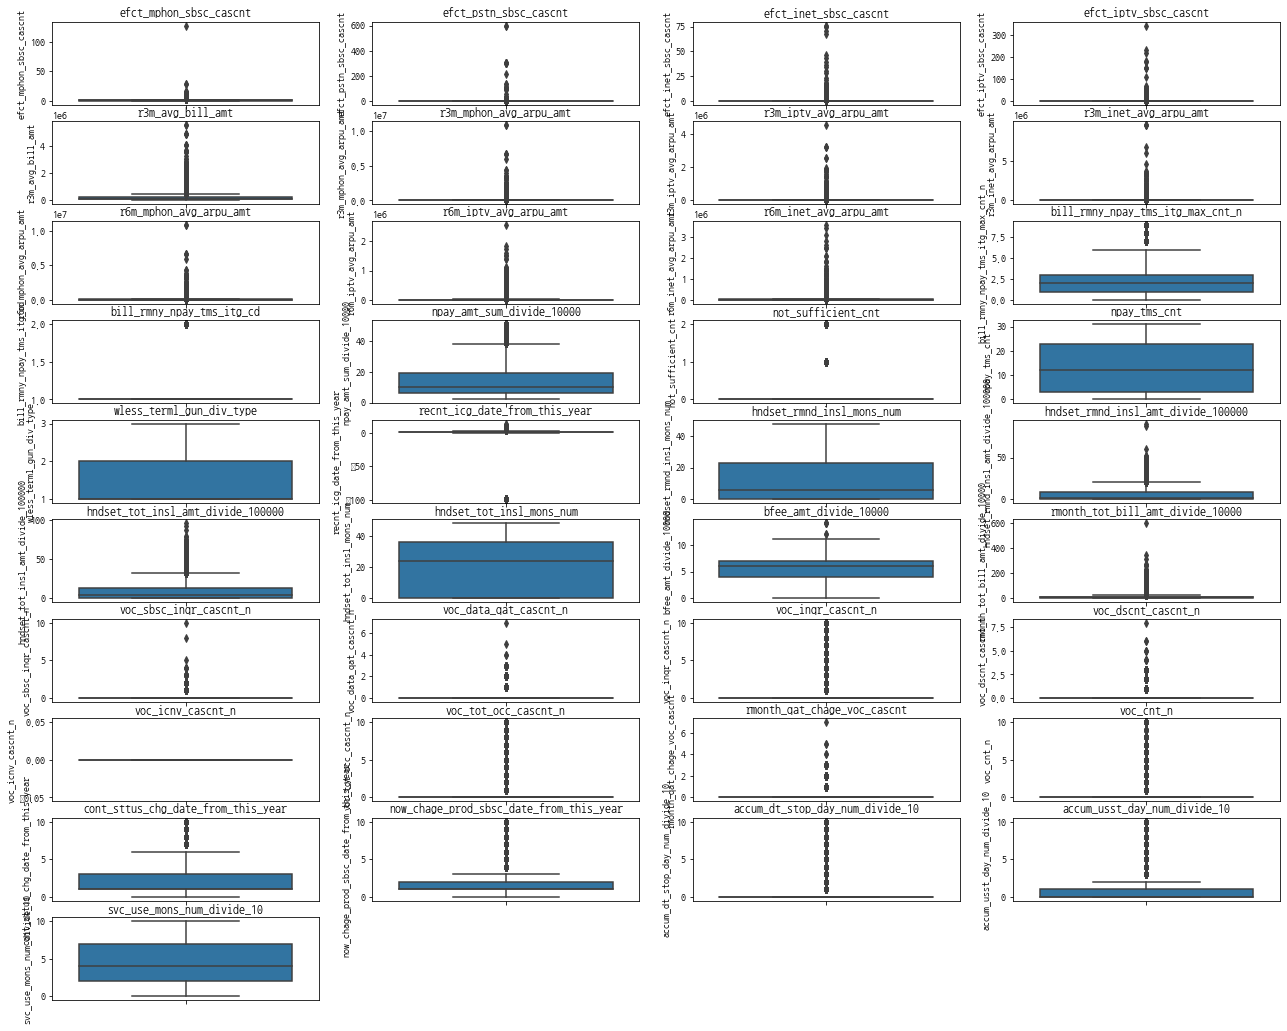

In [77]:
plt.figure(figsize=(22,18))
for i, col in enumerate(int_col) :
    ax = plt.subplot(10,4,i+1)
    #total_merge_data3[col].plot(kind='box', ax=ax)
    sns.boxplot(data=total_merge_data3, y=col, ax=ax)
    plt.title(col)

efct_mphon_sbsc_cascnt


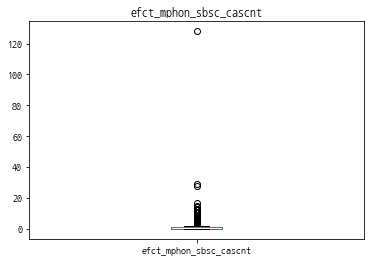

efct_pstn_sbsc_cascnt


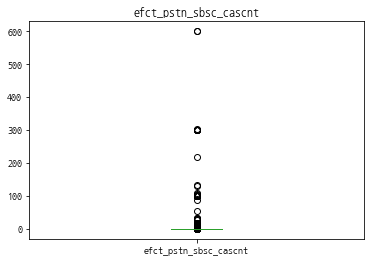

efct_inet_sbsc_cascnt


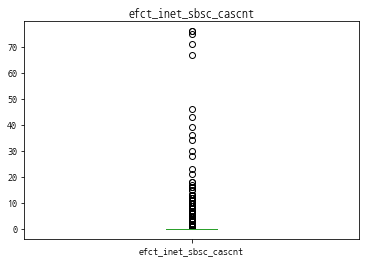

efct_iptv_sbsc_cascnt


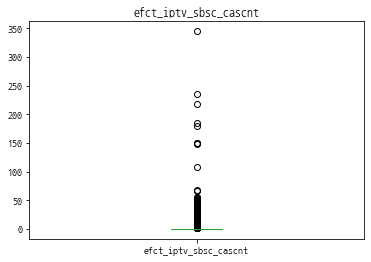

r3m_avg_bill_amt


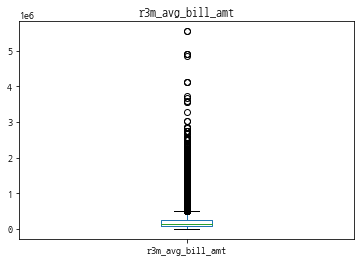

r3m_mphon_avg_arpu_amt


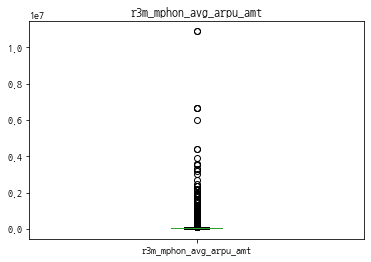

r3m_iptv_avg_arpu_amt


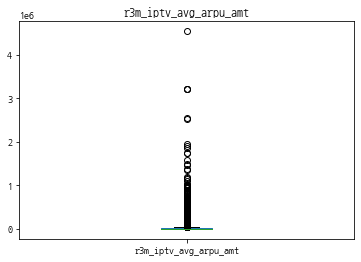

r3m_inet_avg_arpu_amt


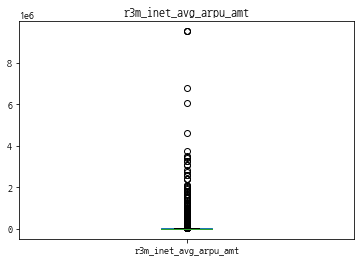

r6m_mphon_avg_arpu_amt


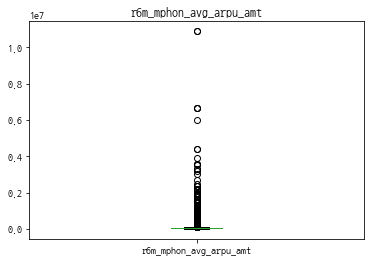

r6m_iptv_avg_arpu_amt


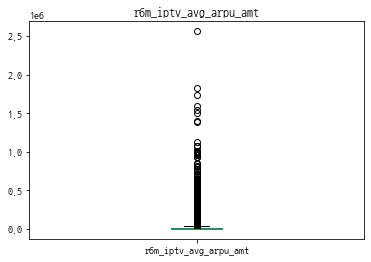

r6m_inet_avg_arpu_amt


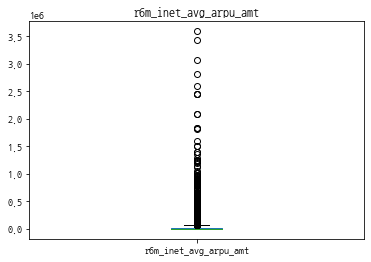

bill_rmny_npay_tms_itg_max_cnt_n


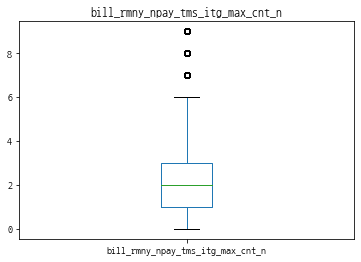

bill_rmny_npay_tms_itg_cd


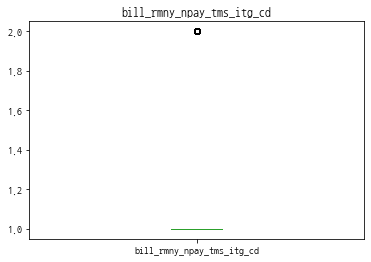

npay_amt_sum_divide_10000


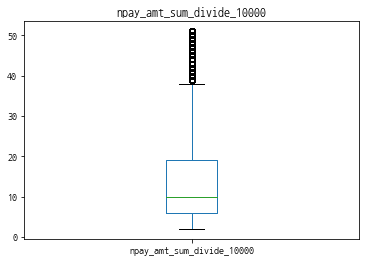

not_sufficient_cnt


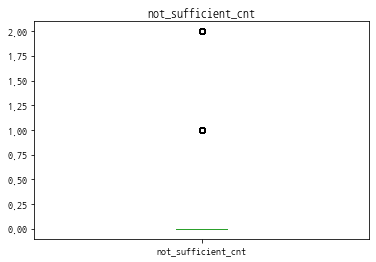

npay_tms_cnt


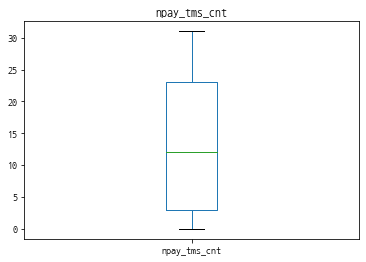

wless_terml_gun_div_type


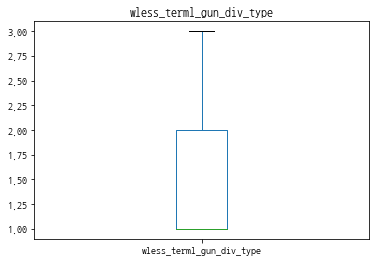

recnt_icg_date_from_this_year


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


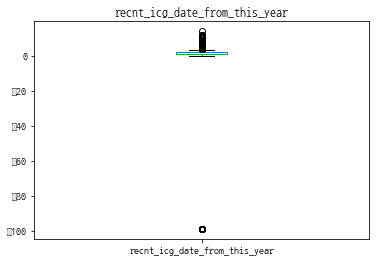

hndset_rmnd_insl_mons_num


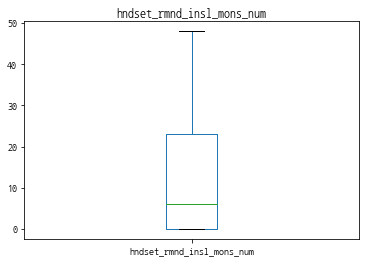

hndset_rmnd_insl_amt_divide_100000


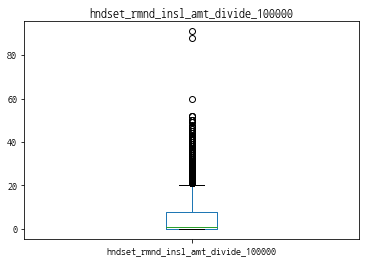

hndset_tot_insl_amt_divide_100000


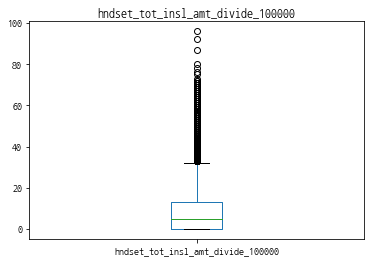

hndset_tot_insl_mons_num


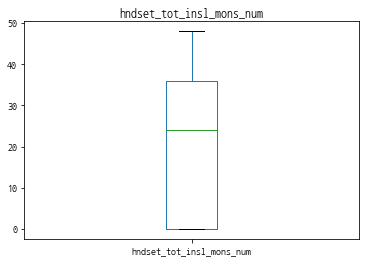

bfee_amt_divide_10000


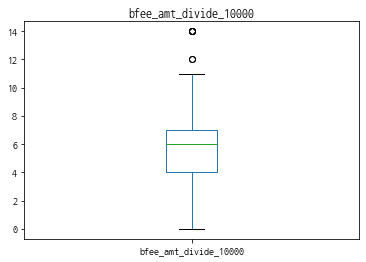

rmonth_tot_bill_amt_divide_10000


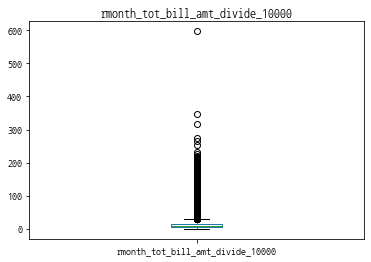

voc_sbsc_inqr_cascnt_n


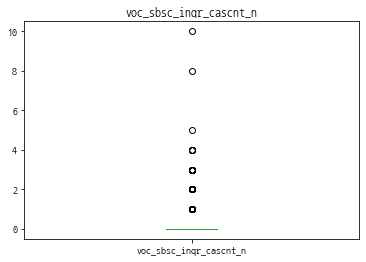

voc_data_qat_cascnt_n


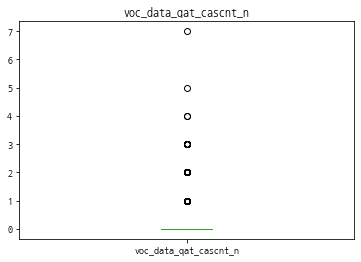

voc_inqr_cascnt_n


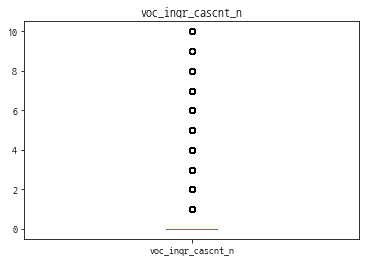

voc_dscnt_cascnt_n


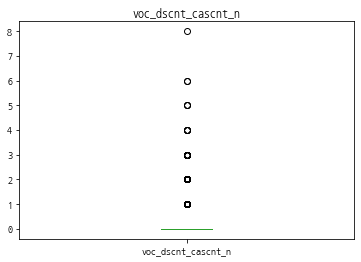

voc_icnv_cascnt_n


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


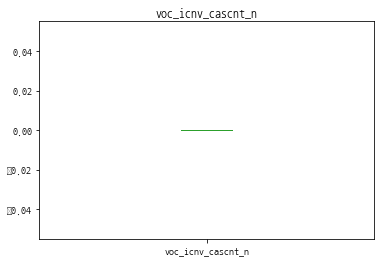

voc_tot_occ_cascnt_n


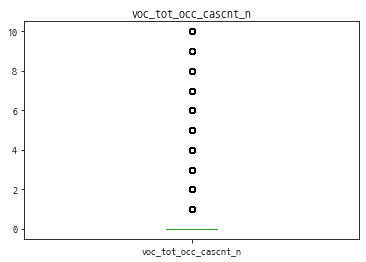

rmonth_qat_chage_voc_cascnt


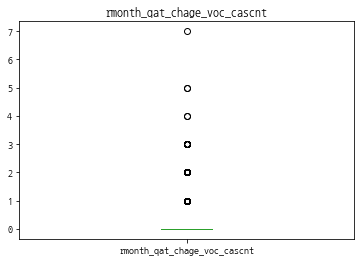

voc_cnt_n


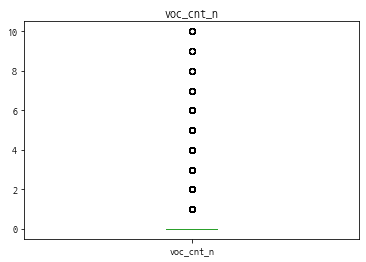

cont_sttus_chg_date_from_this_year


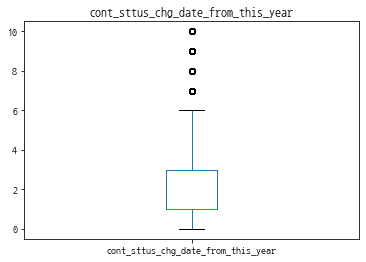

now_chage_prod_sbsc_date_from_this_year


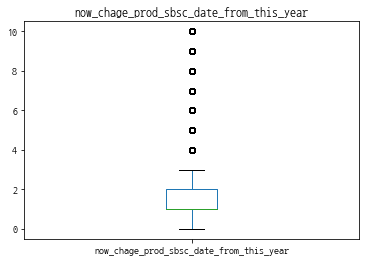

accum_dt_stop_day_num_divide_10


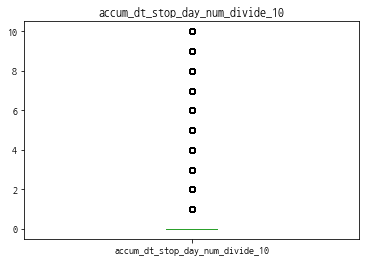

accum_usst_day_num_divide_10


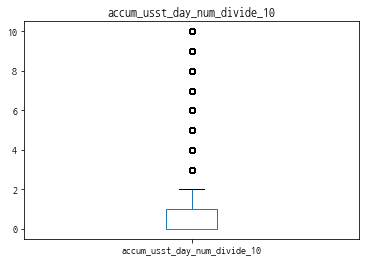

svc_use_mons_num_divide_10


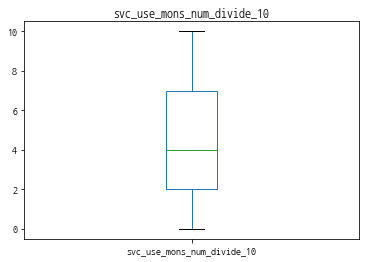

In [78]:
for col in int_col :
    print(col)
    plt.title(col)
    total_merge_data3[col].plot(kind='box')
    plt.show()

### 
### 이상치 확인 
- efct_mphon_sbsc_cascnt > 120
- efct_pstn_sbsc_cascnt > 500
- efct_inet_sbsc_cascnt > 60
- efct_iptv_sbsc_cascnt > 300
- r3m_avg_bill_amt > 5 * 1000000
- r3m_mphon_avg_arpu_amt > 1 * 10000000
- r3m_iptv_avg_arpu_amt > 4 * 1000000
- r3m_inet_avg_arpu_amt > 8 * 1000000
- r6m_mphon_avg_arpu_amt > 1 * 10000000
- r6m_iptv_avg_arpu_amt  > 2.0 * 1000000
- r6m_inet_avg_arpu_amt > 2.3 * 1000000
- hndset_rmnd_insl_amt_divide_100000 > 80
- hndset_tot_insl_amt_divide_100000 > 82
- rmonth_tot_bill_amt_divide_10000 > 500
- recnt_icg_date_from_this_year' == -99

#### 
#### recnt_icg_date_from_this_year 컬럼의 -99 값을 최빈값 1로 변경

In [79]:
total_merge_data3['recnt_icg_date_from_this_year'].value_counts()

 1     78461
 2     48985
 3     19130
-99    18137
 0     14049
 4      7087
 5      2739
 6      1010
 7       270
 8        69
 9        27
 10       25
 11        6
 12        4
 14        1
Name: recnt_icg_date_from_this_year, dtype: int64

In [80]:
cond = total_merge_data3['recnt_icg_date_from_this_year'] == -99

In [81]:
total_merge_data3.loc[cond, 'recnt_icg_date_from_this_year'] = 1

In [82]:
total_merge_data3.loc[cond, 'recnt_icg_date_from_this_year']

52        1
64        1
72        1
95        1
108       1
         ..
189928    1
189944    1
189948    1
189950    1
189996    1
Name: recnt_icg_date_from_this_year, Length: 18137, dtype: int64

#### 
#### Train 데이터셋에서 이상치 삭제(TEST 데이터셋에 이상치는 제외해야 함).

In [83]:
c1 = total_merge_data3['efct_mphon_sbsc_cascnt'] > 120
c2 = total_merge_data3['efct_pstn_sbsc_cascnt'] > 500
c3 = total_merge_data3['efct_inet_sbsc_cascnt'] > 60
c4 = total_merge_data3['efct_iptv_sbsc_cascnt'] > 300
c5 = total_merge_data3['r3m_avg_bill_amt'] > 5*1000000
c6 = total_merge_data3['r3m_mphon_avg_arpu_amt'] > 1*10000000
c7 = total_merge_data3['r3m_iptv_avg_arpu_amt'] > 4*1000000
c8 = total_merge_data3['r3m_inet_avg_arpu_amt'] > 8*1000000
c9 = total_merge_data3['r6m_mphon_avg_arpu_amt'] > 1*10000000
c10 = total_merge_data3['r6m_iptv_avg_arpu_amt'] > 2*1000000
c11 = total_merge_data3['r6m_inet_avg_arpu_amt'] > 2.3*1000000
c12 = total_merge_data3['hndset_rmnd_insl_amt_divide_100000'] > 80
c13 = total_merge_data3['hndset_tot_insl_amt_divide_100000'] > 82
c14 = total_merge_data3['rmonth_tot_bill_amt_divide_10000'] > 500

In [84]:
del_cnt = 0
for i in [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14]:
    print(total_merge_data3[i].index.values, total_merge_data3[i].index.values.size)
    cnt = total_merge_data3[i].index.values.size
    del_cnt = del_cnt + cnt

print('delete row count : ', del_cnt)

[140302] 1
[104971 179806] 2
[104143 124724 156842 167020 189445] 5
[156842] 1
[114170 172498] 2
[147337 167404] 2
[139180] 1
[ 92683 172175 182116] 3
[147337 167404] 2
[27225] 1
[ 23329  60967  76243 104143 124724 124869 143939 167020] 8
[114170 172498] 2
[111859 114170 172498] 3
[114170] 1
delete row count :  34


In [85]:
test_data = total_merge_data3[c1 | c2 | c3 | c4 | c5 | c6 | c7 | c8 | c9 | c10 | c11 | c12 | c13 | c14]

In [86]:
del_index = test_data[test_data['label_payment_yn'] != 0].index

In [87]:
len(del_index)

4

In [88]:
del_index

Int64Index([23329, 27225, 60967, 76243], dtype='int64')

In [89]:
total_merge_data3.shape

(190000, 58)

In [90]:
total_merge_data3.drop(del_index, axis=0, inplace=True)

In [91]:
total_merge_data3.shape

(189996, 58)

#### 
#### bill_rmny_npay_tms_itg_max_cnt_n ,bill_rmny_npay_tms_itg_cd, not_sufficient_cnt, voc_icnv_cascnt_n : 4개 컬럼 분포 확인


In [92]:
total_merge_data3['bill_rmny_npay_tms_itg_max_cnt_n'].value_counts(normalize=True)

2    0.369097
1    0.253132
3    0.193083
0    0.123939
4    0.028869
5    0.012495
6    0.007321
7    0.006011
8    0.003068
9    0.002984
Name: bill_rmny_npay_tms_itg_max_cnt_n, dtype: float64

In [93]:
total_merge_data3['bill_rmny_npay_tms_itg_cd'].value_counts(normalize=True)

1    0.822596
2    0.177404
Name: bill_rmny_npay_tms_itg_cd, dtype: float64

In [94]:
total_merge_data3['not_sufficient_cnt'].value_counts(normalize=True)

0    0.821533
1    0.177967
2    0.000500
Name: not_sufficient_cnt, dtype: float64

In [95]:
total_merge_data3['voc_icnv_cascnt_n'].value_counts(normalize=True)

0    1.0
Name: voc_icnv_cascnt_n, dtype: float64

## 
## 10. voc_icnv_cascnt_n 컬럼 삭제

In [96]:
total_merge_data3.shape

(189996, 58)

In [97]:
total_merge_data3.drop(['voc_icnv_cascnt_n'], axis=1, inplace=True)

In [98]:
total_merge_data3.shape

(189996, 57)

## 
## 11. age 컬럼 숫자형 변환

In [99]:
# '_' 값을 가진 건수
print(total_merge_data3[total_merge_data3['age_itg_cd'] == '_']['age_itg_cd'].count())

2069


In [100]:
total_merge_data3['age_itg_cd'].replace('_', np.nan, inplace=True)

In [101]:
print(total_merge_data3['age_itg_cd'].isnull().sum())

2069


In [102]:
# null 대신 넣은 중간값 확인
print(total_merge_data3['age_itg_cd'].median())

38.0


In [103]:
total_merge_data3['age_itg_cd'].fillna(38, inplace=True)

In [104]:
print(total_merge_data3['age_itg_cd'].isnull().sum())

0


In [105]:
total_merge_data3['age_itg_cd'] = total_merge_data3['age_itg_cd'].astype(int)

In [106]:
total_merge_data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189996 entries, 0 to 189999
Data columns (total 57 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       189996 non-null  object 
 1   label_payment_yn                         189996 non-null  object 
 2   age_itg_cd                               189996 non-null  int64  
 3   inet_sbsc_yn                             189996 non-null  object 
 4   iptv_sbsc_yn                             189996 non-null  object 
 5   efct_mphon_sbsc_cascnt                   189996 non-null  int64  
 6   efct_pstn_sbsc_cascnt                    189996 non-null  int64  
 7   efct_inet_sbsc_cascnt                    189996 non-null  int64  
 8   efct_iptv_sbsc_cascnt                    189996 non-null  int64  
 9   mphon_comb_yn                            189996 non-null  object 
 10  inet_comb_yn                    

In [107]:
total_merge_data3.describe()

,age_itg_cd,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,r3m_avg_bill_amt,r3m_mphon_avg_arpu_amt,r3m_iptv_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,...,rmonth_qat_chage_voc_cascnt,voc_cnt_n,cont_sttus_chg_date_from_this_year,now_chage_prod_sbsc_date_from_this_year,accum_dt_stop_day_num_divide_10,accum_usst_day_num_divide_10,svc_use_mons_num_divide_10,tm_npay_cnt,sm_npay_cnt,sm_use_stop_cnt
count,189996.000000,189996.000000,189996.000000,189996.000000,189996.000000,1.899960e+05,1.899960e+05,1.899960e+05,1.899960e+05,1.899960e+05,...,189996.000000,189996.000000,189996.000000,189996.000000,189996.000000,189996.000000,189996.000000,189996.000000,189996.000000,189996.000000
mean,39.710868,0.767127,0.157077,0.277080,0.388477,2.147811e+05,6.641399e+04,1.114313e+04,1.464184e+04,6.711043e+04,...,0.008769,0.205889,2.237426,1.910167,0.669967,1.487547,4.513879,0.141508,0.356913,0.601139
std,15.028201,0.851516,2.931545,0.757518,1.773951,2.367341e+05,8.431526e+04,3.662037e+04,6.401263e+04,8.402500e+04,...,0.105218,0.611348,2.277013,1.578509,2.323624,3.106180,3.341180,0.564983,1.016734,1.144005
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,0.000000,0.000000,0.000000,8.023200e+04,3.888575e+04,0.000000e+00,0.000000e+00,3.917300e+04,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,38.000000,1.000000,0.000000,0.000000,0.000000,1.317815e+05,5.442150e+04,0.000000e+00,0.000000e+00,5.479300e+04,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000,0.000000,0.000000,2.490880e+05,7.512000e+04,1.464900e+04,2.492000e+04,7.577350e+04,...,0.000000,0.000000,3.000000,2.000000,0.000000,1.000000,7.000000,0.000000,0.000000,1.000000
max,117.000000,128.000000,600.000000,76.000000,345.000000,5.540115e+06,1.088502e+07,4.542817e+06,9.520145e+06,1.088502e+07,...,7.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,17.000000,7.000000,7.000000


## 
## 12. 컬럼값의 범위가 너무 크게 차이나는 컬럼에 대해 log1p 스케일 적용

In [108]:
cols = total_merge_data3.describe().columns

for col in cols:
    Max = total_merge_data3[col].max()
    Min = total_merge_data3[col].min()
    if Max - Min > 1000 :
        print(f'{col} --> Min : {Min},  Max : {Max}')
        total_merge_data3[col] = np.log1p(total_merge_data3[col])

r3m_avg_bill_amt --> Min : 0,  Max : 5540115
r3m_mphon_avg_arpu_amt --> Min : 0,  Max : 10885017
r3m_iptv_avg_arpu_amt --> Min : 0,  Max : 4542817
r3m_inet_avg_arpu_amt --> Min : 0,  Max : 9520145
r6m_mphon_avg_arpu_amt --> Min : 0,  Max : 10885017
r6m_iptv_avg_arpu_amt --> Min : 0,  Max : 1821796
r6m_inet_avg_arpu_amt --> Min : 0,  Max : 3435917


In [109]:
total_merge_data4 = total_merge_data3.copy()

## 
## 13. Feature 늘려보자 : cnt, amt 다 더하고, 평균 구해보자

In [110]:
col_list = total_merge_data4.columns.tolist()

In [111]:
cnt_list = []
voc_list = []
efct_list = []
amt_list = []
for col in col_list:
    if 'voc_' in col and col != 'voc_tot_occ_cascnt_n':
        voc_list.append(col)
    elif 'efct_' in col:
        efct_list.append(col)
    elif 'cnt' in col:
        #print('CNT: ', col)
        cnt_list.append(col)
    elif 'amt' in col and col != 'r3m_avg_bill_amt_100000_over_yn_Y' and col != 'r3m_avg_bill_amt_100000_over_yn':
        #print('CNT: ', col)
        amt_list.append(col)    

print('CNT: ', cnt_list)
print('VOC: ', voc_list)
print('EFCT: ', efct_list)
print('AMT: ', amt_list)

CNT:  ['bill_rmny_npay_tms_itg_max_cnt_n', 'not_sufficient_cnt', 'npay_tms_cnt', 'recnt_icg_date_from_this_year', 'voc_tot_occ_cascnt_n', 'tm_npay_cnt', 'sm_npay_cnt', 'sm_use_stop_cnt']
VOC:  ['voc_sbsc_inqr_cascnt_n', 'voc_data_qat_cascnt_n', 'voc_inqr_cascnt_n', 'voc_dscnt_cascnt_n', 'rmonth_qat_chage_voc_cascnt', 'voc_cnt_n']
EFCT:  ['efct_mphon_sbsc_cascnt', 'efct_pstn_sbsc_cascnt', 'efct_inet_sbsc_cascnt', 'efct_iptv_sbsc_cascnt']
AMT:  ['r3m_avg_bill_amt', 'r3m_mphon_avg_arpu_amt', 'r3m_iptv_avg_arpu_amt', 'r3m_inet_avg_arpu_amt', 'r6m_mphon_avg_arpu_amt', 'r6m_iptv_avg_arpu_amt', 'r6m_inet_avg_arpu_amt', 'npay_amt_sum_divide_10000', 'hndset_rmnd_insl_amt_divide_100000', 'hndset_tot_insl_amt_divide_100000', 'bfee_amt_divide_10000', 'rmonth_tot_bill_amt_divide_10000']


In [112]:
cnt_len = len(cnt_list)
voc_len = len(voc_list)
efct_len = len(efct_list)
amt_len = len(amt_list)
cnt_len, voc_len, efct_len, amt_len

(8, 6, 4, 12)

In [113]:
def nabbu_calc(row):
    if row['hndset_tot_insl_mons_num'] != 0 :
        return row['hndset_tot_insl_amt_divide_100000'] / row['hndset_tot_insl_mons_num']
    else :
        return 0

In [114]:
total_merge_data4['NABBU_MONTH_MONEY'] = total_merge_data4.apply(nabbu_calc, axis=1)

In [115]:
total_merge_data4['NABBU_MONTH'] = total_merge_data4['hndset_tot_insl_mons_num'] - total_merge_data4['hndset_rmnd_insl_mons_num']

In [116]:
total_merge_data4['NABBU_TOTAL_MONEY'] = total_merge_data4['NABBU_MONTH'] * total_merge_data4['NABBU_MONTH_MONEY']

In [117]:
total_merge_data4['R3M_AMT'] = total_merge_data4['r3m_mphon_avg_arpu_amt'] + total_merge_data4['r3m_iptv_avg_arpu_amt'] + total_merge_data4['r3m_inet_avg_arpu_amt']
total_merge_data4['R6M_AMT'] = total_merge_data4['r6m_mphon_avg_arpu_amt'] + total_merge_data4['r6m_iptv_avg_arpu_amt'] + total_merge_data4['r6m_inet_avg_arpu_amt']

total_merge_data4['R3M_AMT_ABG'] = total_merge_data4['R3M_AMT'] / 3
total_merge_data4['R6M_AMT_AVG'] = total_merge_data4['R6M_AMT'] / 3

In [118]:
total_merge_data4['UNUSE_STOP_DAY'] = total_merge_data4['accum_dt_stop_day_num_divide_10'] + total_merge_data4['accum_usst_day_num_divide_10']

In [119]:
total_merge_data4['CNT'] = 0
total_merge_data4['VOC'] = 0
total_merge_data4['EFCT'] = 0
total_merge_data4['AMT'] = 0

for cnt in cnt_list:
    #print(cnt)
    total_merge_data4['CNT'] = total_merge_data4['CNT'] + total_merge_data4[cnt]

for voc in voc_list:
    #print(cnt)
    total_merge_data4['VOC'] = total_merge_data4['VOC'] + total_merge_data4[voc]
    
for efct in efct_list:
    #print(cnt)
    total_merge_data4['EFCT'] = total_merge_data4['EFCT'] + total_merge_data4[efct]

for amt in amt_list:
    #print(cnt)
    total_merge_data4['AMT'] = total_merge_data4['AMT'] + total_merge_data4[amt]    

In [120]:
total_merge_data4['CNT_MEAN'] = total_merge_data4['CNT'] / cnt_len
total_merge_data4['AMT_MEAN'] = total_merge_data4['AMT'] / amt_len

In [121]:
total_merge_data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189996 entries, 0 to 189999
Data columns (total 71 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       189996 non-null  object 
 1   label_payment_yn                         189996 non-null  object 
 2   age_itg_cd                               189996 non-null  int64  
 3   inet_sbsc_yn                             189996 non-null  object 
 4   iptv_sbsc_yn                             189996 non-null  object 
 5   efct_mphon_sbsc_cascnt                   189996 non-null  int64  
 6   efct_pstn_sbsc_cascnt                    189996 non-null  int64  
 7   efct_inet_sbsc_cascnt                    189996 non-null  int64  
 8   efct_iptv_sbsc_cascnt                    189996 non-null  int64  
 9   mphon_comb_yn                            189996 non-null  object 
 10  inet_comb_yn                    

## 
## 14. 문자형 컬럼을 One-Hot-Encoding

In [122]:
total_merge_data4['label_payment_yn'].value_counts()

0    100000
N     45482
Y     44514
Name: label_payment_yn, dtype: int64

In [123]:
len(total_merge_data4.columns)

71

In [124]:
# total_merge_data4 데이터에서 int 컬럼 발췌
obj_cols = total_merge_data4.columns[total_merge_data4.dtypes == 'object'].to_list()
obj_cols

['id',
 'label_payment_yn',
 'inet_sbsc_yn',
 'iptv_sbsc_yn',
 'mphon_comb_yn',
 'inet_comb_yn',
 'iptv_comb_yn',
 'npay_yn',
 'r6m_inet_pssn_comb_yn',
 'r6m_iptv_pssn_comb_yn',
 'pay_way_nm',
 'acrnd_dsp_meth_nm',
 'bprod_lctg_nm',
 'wless_terml_gun_div_nm',
 'hndset_rmnd_insl_mons_yn',
 'r3m_avg_bill_amt_100000_over_yn',
 'insur_prod_sbsc_yn']

In [125]:
obj_cols = list(set(obj_cols) - set(['id','label_payment_yn']))
obj_cols

['npay_yn',
 'inet_sbsc_yn',
 'iptv_comb_yn',
 'r6m_iptv_pssn_comb_yn',
 'r3m_avg_bill_amt_100000_over_yn',
 'iptv_sbsc_yn',
 'hndset_rmnd_insl_mons_yn',
 'bprod_lctg_nm',
 'acrnd_dsp_meth_nm',
 'pay_way_nm',
 'r6m_inet_pssn_comb_yn',
 'mphon_comb_yn',
 'inet_comb_yn',
 'wless_terml_gun_div_nm',
 'insur_prod_sbsc_yn']

In [126]:
total_merge_data4 = pd.get_dummies(data=total_merge_data4, columns=obj_cols, drop_first=True)
total_merge_data4

,id,label_payment_yn,age_itg_cd,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,r3m_avg_bill_amt,r3m_mphon_avg_arpu_amt,r3m_iptv_avg_arpu_amt,...,acrnd_dsp_meth_nm_모바일,acrnd_dsp_meth_nm_스마트(앱),pay_way_nm_은행계좌 자동이체,pay_way_nm_지로,r6m_inet_pssn_comb_yn_Y,mphon_comb_yn_Y,inet_comb_yn_Y,wless_terml_gun_div_nm_LTE스마트폰,wless_terml_gun_div_nm_기타,insur_prod_sbsc_yn_Y
0,ED1000001,N,76,1,0,0,0,11.858131,10.200067,0.000000,...,0,1,0,0,0,1,0,1,0,0
1,ED1000002,N,71,0,0,0,0,11.064010,10.877066,0.000000,...,1,0,0,1,0,0,0,0,0,1
2,ED1000003,N,21,0,0,0,0,11.366789,10.868416,0.000000,...,1,0,0,1,0,1,1,0,0,1
3,ED1000004,N,61,1,0,1,1,12.329250,10.924841,6.184149,...,1,0,1,0,1,1,1,0,0,1
4,ED1000005,Y,28,0,0,0,0,11.394547,10.624201,0.000000,...,1,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189995,TD1099996,0,44,0,0,0,0,11.269171,11.254595,0.000000,...,1,0,0,1,0,0,0,1,0,0
189996,TD1099997,0,53,0,1,1,1,11.600011,0.000000,10.580556,...,0,0,1,0,1,0,1,0,1,0
189997,TD1099998,0,49,0,2,0,0,12.061307,11.215597,0.000000,...,1,0,0,0,1,0,0,1,0,1
189998,TD1099999,0,18,1,0,0,0,11.568965,10.905075,0.000000,...,1,0,0,0,0,1,1,0,0,1


In [127]:
total_merge_data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189996 entries, 0 to 189999
Data columns (total 75 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       189996 non-null  object 
 1   label_payment_yn                         189996 non-null  object 
 2   age_itg_cd                               189996 non-null  int64  
 3   efct_mphon_sbsc_cascnt                   189996 non-null  int64  
 4   efct_pstn_sbsc_cascnt                    189996 non-null  int64  
 5   efct_inet_sbsc_cascnt                    189996 non-null  int64  
 6   efct_iptv_sbsc_cascnt                    189996 non-null  int64  
 7   r3m_avg_bill_amt                         189996 non-null  float64
 8   r3m_mphon_avg_arpu_amt                   189996 non-null  float64
 9   r3m_iptv_avg_arpu_amt                    189996 non-null  float64
 10  r3m_inet_avg_arpu_amt           

# 
# Train , Test 분리 

In [128]:
total_merge_data4['label_payment_yn'].value_counts()

0    100000
N     45482
Y     44514
Name: label_payment_yn, dtype: int64

In [129]:
train_cond = (total_merge_data4['label_payment_yn'] != 0)

In [130]:
final_data = total_merge_data4[train_cond]

In [131]:
final_data.shape

(89996, 75)

In [132]:
final_data = final_data.drop(['id'], axis=1)

In [133]:
final_data.shape

(89996, 74)

In [134]:
final_data = pd.get_dummies(data=final_data, columns=['label_payment_yn'], drop_first=True)

In [135]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89996 entries, 0 to 89999
Data columns (total 74 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age_itg_cd                               89996 non-null  int64  
 1   efct_mphon_sbsc_cascnt                   89996 non-null  int64  
 2   efct_pstn_sbsc_cascnt                    89996 non-null  int64  
 3   efct_inet_sbsc_cascnt                    89996 non-null  int64  
 4   efct_iptv_sbsc_cascnt                    89996 non-null  int64  
 5   r3m_avg_bill_amt                         89996 non-null  float64
 6   r3m_mphon_avg_arpu_amt                   89996 non-null  float64
 7   r3m_iptv_avg_arpu_amt                    89996 non-null  float64
 8   r3m_inet_avg_arpu_amt                    89996 non-null  float64
 9   r6m_mphon_avg_arpu_amt                   89996 non-null  float64
 10  r6m_iptv_avg_arpu_amt                    89996

In [136]:
X = final_data.drop(['label_payment_yn_Y'], axis=1)
y = final_data['label_payment_yn_Y']

In [137]:
X.shape, y.shape

((89996, 73), (89996,))

### 
### TEST 데이터셋 분리 및 ID 기억해 놓야 함.

In [138]:
test_cond = (total_merge_data4['label_payment_yn'] == 0)

In [139]:
final_X_test = total_merge_data4[test_cond]

In [140]:
final_X_test.shape

(100000, 75)

In [141]:
final_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 90000 to 189999
Data columns (total 75 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       100000 non-null  object 
 1   label_payment_yn                         100000 non-null  object 
 2   age_itg_cd                               100000 non-null  int64  
 3   efct_mphon_sbsc_cascnt                   100000 non-null  int64  
 4   efct_pstn_sbsc_cascnt                    100000 non-null  int64  
 5   efct_inet_sbsc_cascnt                    100000 non-null  int64  
 6   efct_iptv_sbsc_cascnt                    100000 non-null  int64  
 7   r3m_avg_bill_amt                         100000 non-null  float64
 8   r3m_mphon_avg_arpu_amt                   100000 non-null  float64
 9   r3m_iptv_avg_arpu_amt                    100000 non-null  float64
 10  r3m_inet_avg_arpu_amt       

### 
### TEST ID 뽑아놓기

In [142]:
TEST_ID = final_X_test['id']

In [143]:
TEST_ID = TEST_ID.reset_index(drop=True)

In [144]:
type(TEST_ID)

pandas.core.series.Series

In [145]:
TEST_ID.shape

(100000,)

In [146]:
final_X_test = final_X_test.drop(['id', 'label_payment_yn'], axis=1)

In [147]:
final_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 90000 to 189999
Data columns (total 73 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   age_itg_cd                               100000 non-null  int64  
 1   efct_mphon_sbsc_cascnt                   100000 non-null  int64  
 2   efct_pstn_sbsc_cascnt                    100000 non-null  int64  
 3   efct_inet_sbsc_cascnt                    100000 non-null  int64  
 4   efct_iptv_sbsc_cascnt                    100000 non-null  int64  
 5   r3m_avg_bill_amt                         100000 non-null  float64
 6   r3m_mphon_avg_arpu_amt                   100000 non-null  float64
 7   r3m_iptv_avg_arpu_amt                    100000 non-null  float64
 8   r3m_inet_avg_arpu_amt                    100000 non-null  float64
 9   r6m_mphon_avg_arpu_amt                   100000 non-null  float64
 10  r6m_iptv_avg_arpu_amt       

### 
### Train / Test 데이터셋 분리

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [149]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, final_X_test.shape

((62997, 73), (26999, 73), (62997,), (26999,), (100000, 73))

In [150]:
X_train.head()

,age_itg_cd,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,r3m_avg_bill_amt,r3m_mphon_avg_arpu_amt,r3m_iptv_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,...,acrnd_dsp_meth_nm_모바일,acrnd_dsp_meth_nm_스마트(앱),pay_way_nm_은행계좌 자동이체,pay_way_nm_지로,r6m_inet_pssn_comb_yn_Y,mphon_comb_yn_Y,inet_comb_yn_Y,wless_terml_gun_div_nm_LTE스마트폰,wless_terml_gun_div_nm_기타,insur_prod_sbsc_yn_Y
48440,33,2,2,3,2,12.550421,11.588951,10.938521,11.386625,11.492600,...,0,0,1,0,1,1,1,1,0,1
8911,24,1,0,0,0,11.986940,10.463617,0.000000,0.000000,12.766268,...,1,0,0,1,0,0,0,1,0,1
75289,25,1,0,0,0,12.893717,11.829151,0.000000,0.000000,11.482848,...,1,0,1,0,0,0,0,0,0,0
25294,57,0,0,0,0,10.694555,10.673503,0.000000,0.000000,10.673503,...,1,0,0,1,0,1,1,1,0,0
6669,49,0,1,1,0,11.278101,0.000000,0.000000,11.053806,0.000000,...,0,0,1,0,1,0,1,0,1,0


In [151]:
y_train.head()

48440    1
8911     1
75289    1
25294    0
6669     1
Name: label_payment_yn_Y, dtype: uint8

In [152]:
X_test.tail()

,age_itg_cd,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,r3m_avg_bill_amt,r3m_mphon_avg_arpu_amt,r3m_iptv_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,...,acrnd_dsp_meth_nm_모바일,acrnd_dsp_meth_nm_스마트(앱),pay_way_nm_은행계좌 자동이체,pay_way_nm_지로,r6m_inet_pssn_comb_yn_Y,mphon_comb_yn_Y,inet_comb_yn_Y,wless_terml_gun_div_nm_LTE스마트폰,wless_terml_gun_div_nm_기타,insur_prod_sbsc_yn_Y
29107,22,0,0,0,0,11.328991,10.912613,0.000000,0.000000,10.826615,...,0,1,0,1,0,0,0,1,0,0
58726,47,0,0,0,0,12.906337,10.845310,0.000000,9.765432,10.994404,...,0,1,0,1,1,1,1,0,0,1
83407,32,0,0,1,1,12.461645,10.663335,10.713973,10.119083,10.667326,...,0,1,0,0,1,1,1,1,0,0
76638,20,1,0,0,0,11.712964,11.269031,0.000000,0.000000,11.169364,...,1,0,0,1,0,1,1,0,0,1
3653,40,1,0,0,0,10.885884,10.818357,0.000000,0.000000,10.818357,...,1,0,0,1,0,0,0,1,0,0


In [153]:
y_test.tail()

29107    0
58726    1
83407    0
76638    1
3653     1
Name: label_payment_yn_Y, dtype: uint8

### 
### PCA 추가 : 성능 향상에 도움 안되네.ㅠㅠ

In [154]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
final_X_test = final_X_test.reset_index(drop=True)

In [155]:
X_train.shape, X_test.shape, final_X_test.shape

((62997, 73), (26999, 73), (100000, 73))

In [156]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
final_X_test_pca = pca.transform(final_X_test)

In [157]:
X_train_pca.shape, X_test_pca.shape, final_X_test_pca.shape

((62997, 2), (26999, 2), (100000, 2))

In [158]:
df_X_train_pca = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2'])
df_X_test_pca = pd.DataFrame(X_test_pca, columns=['PCA1', 'PCA2'])
df_final_X_test_pca = pd.DataFrame(final_X_test_pca, columns=['PCA1', 'PCA2'])

In [159]:
df_X_train_pca.shape, df_X_test_pca.shape, df_final_X_test_pca.shape

((62997, 2), (26999, 2), (100000, 2))

In [160]:
X_train = pd.concat([X_train, df_X_train_pca], axis=1)
X_test = pd.concat([X_test, df_X_test_pca], axis=1)
final_X_test = pd.concat([final_X_test, df_final_X_test_pca], axis=1)

In [161]:
X_train.shape, X_test.shape, final_X_test.shape

((62997, 75), (26999, 75), (100000, 75))

### 
### 최종 컬럼 이름 나열

In [156]:
col_name = X_train.columns
col_name

Index(['age_itg_cd', 'efct_mphon_sbsc_cascnt', 'efct_pstn_sbsc_cascnt',
       'efct_inet_sbsc_cascnt', 'efct_iptv_sbsc_cascnt', 'r3m_avg_bill_amt',
       'r3m_mphon_avg_arpu_amt', 'r3m_iptv_avg_arpu_amt',
       'r3m_inet_avg_arpu_amt', 'r6m_mphon_avg_arpu_amt',
       'r6m_iptv_avg_arpu_amt', 'r6m_inet_avg_arpu_amt',
       'bill_rmny_npay_tms_itg_max_cnt_n', 'bill_rmny_npay_tms_itg_cd',
       'npay_amt_sum_divide_10000', 'not_sufficient_cnt', 'npay_tms_cnt',
       'wless_terml_gun_div_type', 'recnt_icg_date_from_this_year',
       'hndset_rmnd_insl_mons_num', 'hndset_rmnd_insl_amt_divide_100000',
       'hndset_tot_insl_amt_divide_100000', 'hndset_tot_insl_mons_num',
       'bfee_amt_divide_10000', 'rmonth_tot_bill_amt_divide_10000',
       'voc_sbsc_inqr_cascnt_n', 'voc_data_qat_cascnt_n', 'voc_inqr_cascnt_n',
       'voc_dscnt_cascnt_n', 'voc_tot_occ_cascnt_n',
       'rmonth_qat_chage_voc_cascnt', 'voc_cnt_n',
       'cont_sttus_chg_date_from_this_year',
       'now_chage_prod

# 
# 스케일링

In [157]:
# final_X_test 데이터도 스캐일링 수행

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
#scaler = RobustScaler()
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
final_X_test = scaler.transform(final_X_test)

In [158]:
X_train = pd.DataFrame(data=X_train, columns=col_name)
X_test = pd.DataFrame(data=X_test, columns=col_name)
final_X_test = pd.DataFrame(data=final_X_test, columns=col_name)

In [159]:
X_train.shape, X_test.shape, final_X_test.shape

((62997, 73), (26999, 73), (100000, 73))

In [160]:
X_train.tail()

,age_itg_cd,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,r3m_avg_bill_amt,r3m_mphon_avg_arpu_amt,r3m_iptv_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,...,acrnd_dsp_meth_nm_모바일,acrnd_dsp_meth_nm_스마트(앱),pay_way_nm_은행계좌 자동이체,pay_way_nm_지로,r6m_inet_pssn_comb_yn_Y,mphon_comb_yn_Y,inet_comb_yn_Y,wless_terml_gun_div_nm_LTE스마트폰,wless_terml_gun_div_nm_기타,insur_prod_sbsc_yn_Y
62992,0.421053,0.076923,0.0,0.000000,0.000000,0.776855,0.693662,0.666181,0.698843,0.673893,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
62993,0.289474,0.076923,0.0,0.023256,0.004255,0.795588,0.709272,0.655389,0.696836,0.710055,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
62994,0.263158,0.076923,0.0,0.000000,0.000000,0.834623,0.687356,0.000000,0.000000,0.687834,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
62995,0.114035,0.076923,0.0,0.000000,0.000000,0.745700,0.693168,0.000000,0.000000,0.693155,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
62996,0.377193,0.000000,0.0,0.023256,0.000000,0.778381,0.692406,0.740028,0.684326,0.692412,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


In [161]:
X_test.tail()

,age_itg_cd,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,r3m_avg_bill_amt,r3m_mphon_avg_arpu_amt,r3m_iptv_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,...,acrnd_dsp_meth_nm_모바일,acrnd_dsp_meth_nm_스마트(앱),pay_way_nm_은행계좌 자동이체,pay_way_nm_지로,r6m_inet_pssn_comb_yn_Y,mphon_comb_yn_Y,inet_comb_yn_Y,wless_terml_gun_div_nm_LTE스마트폰,wless_terml_gun_div_nm_기타,insur_prod_sbsc_yn_Y
26994,0.166667,0.000000,0.0,0.000000,0.000000,0.748567,0.722859,0.00000,0.000000,0.717168,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
26995,0.385965,0.000000,0.0,0.000000,0.000000,0.852790,0.718401,0.00000,0.670786,0.728283,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
26996,0.254386,0.000000,0.0,0.023256,0.004255,0.823407,0.706347,0.74238,0.695078,0.706617,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
26997,0.149123,0.076923,0.0,0.000000,0.000000,0.773938,0.746468,0.00000,0.000000,0.739872,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
26998,0.324561,0.076923,0.0,0.000000,0.000000,0.719288,0.716615,0.00000,0.000000,0.716621,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [162]:
final_X_test.tail()

,age_itg_cd,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,r3m_avg_bill_amt,r3m_mphon_avg_arpu_amt,r3m_iptv_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,...,acrnd_dsp_meth_nm_모바일,acrnd_dsp_meth_nm_스마트(앱),pay_way_nm_은행계좌 자동이체,pay_way_nm_지로,r6m_inet_pssn_comb_yn_Y,mphon_comb_yn_Y,inet_comb_yn_Y,wless_terml_gun_div_nm_LTE스마트폰,wless_terml_gun_div_nm_기타,insur_prod_sbsc_yn_Y
99995,0.359649,0.000000,0.000000,0.000000,0.000000,0.744614,0.745512,0.000000,0.000000,0.745519,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
99996,0.438596,0.000000,0.003311,0.023256,0.004255,0.766474,0.000000,0.733135,0.722344,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
99997,0.403509,0.000000,0.006623,0.000000,0.000000,0.796955,0.742929,0.000000,0.000000,0.741195,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
99998,0.131579,0.076923,0.000000,0.000000,0.000000,0.764423,0.722360,0.000000,0.000000,0.721312,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
99999,0.438596,0.076923,0.000000,0.000000,0.000000,0.689134,0.690576,0.000000,0.000000,0.690513,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


# 
# 모델 생성 및 평가

In [163]:
# 모델별 성능 그래프

import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]


#acc를 구해서 시각화해줌
def acc_eval(name_, pred, actual):
    global predictions
    global colors

    acc = (pred==actual).mean()
    my_predictions[name_] = acc


    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() -1
    max_ = 1.2
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()
    
#acc를 구해서 시각화해줌(cross_val_score 사용하는 경우)
def acc_eval_add(name_, acc):
    global predictions
    global colors

    my_predictions[name_] = acc


    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() -1
    max_ = 1.2
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()
    
#실수로 잘못 넣은 경우 해당 모델을 삭제
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

In [164]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [165]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
import time

def get_model_train_eval(name_, model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    start = time.time()
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    spend_time = (time.time()-start)/60
    print(f'\n\n* Total Model Eval Time : {spend_time}\n\n')
    acc_eval(name_, pred, tgt_test)


In [166]:
def save_model(save_name, model, X_test):
    X_test_pred = model.predict(X_test)
    #print('Test prediction shape:',X_test_pred.shape)
    pred_series = pd.Series(X_test_pred)
    final_y_test_df = pd.concat([TEST_ID,pred_series], axis=1)
    final_y_test_df = final_y_test_df.rename(columns={'id':'ID', 0:'Pred'})
    final_y_test_df['Pred'] = final_y_test_df['Pred'].map({0:'N', 1:'Y'})
    #print(final_y_test_df)
    final_y_test_df.to_csv(aidu_framework.config.data_dir + save_name, header=False, index=False)

## 
## Feature Selection

### 1) Feature Selection : RFECV, RFE

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.datasets import make_classification

# SVC classifier 선택
svc = SVC(kernel="linear")

# REFCV로 Feature들을 반복적으로 제거해가면서 학습/평가 수행.  
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy', verbose=2)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.


In [ ]:
col_name = X_train.columns
col_name

### 2) Feature Selection : permutation_importance

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rfc, X_test, y_test, n_repeats=5, random_state=0)

# 가장 평균 permutation importance가 높은 순으로 내림차순 정렬 후 평균 permutation importance값과 표준 편차 출력
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(X_test.columns[i],"   ", np.round(r.importances_mean[i], 4), " +/- ", np.round(r.importances_std[i], 5))

### 
### 3) permutation_importance 따라서 X_train, X_test, final_X_test Feature Engeering

In [ ]:
feature_eng = ['pay_way_nm_지로','npay_yn_Y','svc_use_mons_num_divide_10','cont_sttus_chg_date_from_this_year','pay_way_nm_은행계좌 자동이체','sm_use_stop_cnt','CNT_MEAN','npay_tms_cnt','npay_amt_sum_divide_10000','bill_rmny_npay_tms_itg_cd','tm_npay_cnt','bprod_lctg_nm_기타']

In [ ]:
X_train = X_train[feature_eng]
X_test = X_test[feature_eng]
final_X_test = final_X_test[feature_eng]

In [ ]:
X_train.shape, X_test.shape, final_X_test.shape

## 
## XGB, LGBM, CatBoost 설치 및 Import

In [167]:
get_ipython().system('pip install lightgbm')
get_ipython().system('pip install xgboost')
get_ipython().system('pip install catboost')

Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 2.0 MB 71.8 MB/s eta 0:00:01/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 166.7 MB 129.8 MB/s eta 0:00:01            | 266 kB 36.6 MB/s eta 0:00:05[K     |▉                               | 4.1 MB 36.6 MB/s eta 0:00:056.6 MB/s eta 0:00:05                      | 8.0 MB 36.6 MB/s eta 0:00:0505                       | 12.2 MB 36.6 MB/s eta 0:00:05                       | 12.7 MB 36.6 MB/s eta 0:00:05                           | 13.4 MB 36.6 MB/s eta 0:00:050:05 MB 36.6 MB/s eta 0:00:05 MB 36.6 MB/s eta 0:00:05 |████▌                           | 23.4 MB 36.6 MB/s eta 0:00:04  | 27.3 MB 4.9 MB/s eta 0:00:29                  | 31.1 MB 4.9 MB/s eta 0:00:28��▎                         | 32.7 MB 4.9 MB/s eta 0:00:28[K     |██████▊                     

## 
## 파라미터 설정

In [168]:
day = 1013
try1 = 2

## 
## RamdomForest 성능 테스트

오차 행렬
[[9834 3811]
 [4339 9015]]
정확도: 0.6981, 정밀도: 0.7029, 재현율: 0.6751,    F1: 0.6887, AUC:0.7629


* Total Model Eval Time : 6.066819540659586


          model       acc
0  randomForest  0.698137


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


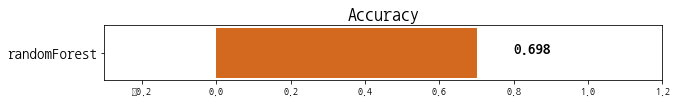

In [169]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1500, n_jobs=-1)
get_model_train_eval('randomForest', rfc, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [170]:
save_name = f'/rfc_merge_{day}_{try1}.csv'
save_model(save_name, rfc, final_X_test)

### 
### feature_importances_

CNT_MEAN                     0.041326
CNT                          0.039596
npay_tms_cnt                 0.038770
r3m_avg_bill_amt             0.038389
AMT_MEAN                     0.035981
AMT                          0.035903
npay_yn_Y                    0.035640
age_itg_cd                   0.033763
r6m_mphon_avg_arpu_amt       0.031940
npay_amt_sum_divide_10000    0.031602
dtype: float64


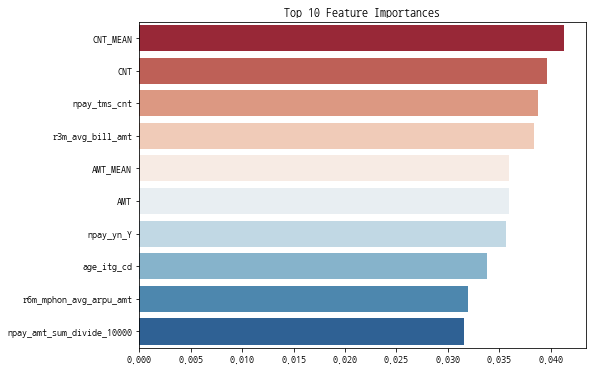

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

grb_importances_values = rfc.feature_importances_
grb_importances = pd.Series(grb_importances_values, index = col_name)
grb_top10 = grb_importances.sort_values(ascending=False)[:10]

print(grb_top10)

plt.rcParams["font.family"] = 'NanumGothicCoding'
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances')
sns.barplot(x=grb_top10, y=grb_top10.index,palette = "RdBu")
plt.show()

## 
## Cat Boosting 성능 테스트

In [ ]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(n_estimators=1500,)
get_model_train_eval('cat_boosting', cbc, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

Learning rate set to 0.041665
0:	learn: 0.6848529	total: 193ms	remaining: 4m 48s
1:	learn: 0.6770386	total: 388ms	remaining: 4m 50s
2:	learn: 0.6697672	total: 585ms	remaining: 4m 51s
3:	learn: 0.6630088	total: 784ms	remaining: 4m 53s
4:	learn: 0.6567985	total: 992ms	remaining: 4m 56s
5:	learn: 0.6513580	total: 1.19s	remaining: 4m 56s
6:	learn: 0.6464402	total: 1.38s	remaining: 4m 55s
7:	learn: 0.6419847	total: 1.49s	remaining: 4m 38s
8:	learn: 0.6376043	total: 1.69s	remaining: 4m 40s
9:	learn: 0.6336679	total: 1.98s	remaining: 4m 55s
10:	learn: 0.6302110	total: 2.09s	remaining: 4m 43s
11:	learn: 0.6271302	total: 2.4s	remaining: 4m 57s
12:	learn: 0.6242360	total: 2.58s	remaining: 4m 55s
13:	learn: 0.6213467	total: 2.79s	remaining: 4m 56s
14:	learn: 0.6188294	total: 2.98s	remaining: 4m 55s
15:	learn: 0.6166396	total: 3.18s	remaining: 4m 55s
16:	learn: 0.6144874	total: 3.38s	remaining: 4m 55s
17:	learn: 0.6123740	total: 3.59s	remaining: 4m 55s
18:	learn: 0.6104493	total: 3.78s	remaining: 

In [ ]:
save_name = f'/cbc_merge_{day}_{try1}.csv'
save_model(save_name, cbc, final_X_test)

## 
## XGB 성능 테스트

In [ ]:
from xgboost import XGBClassifier
xgbm_clf = XGBClassifier()
get_model_train_eval('xgbm_clf', xgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
save_name = f'/xgb_merge_{day}_{try1}.csv'
save_model(save_name, xgbm_clf, final_X_test)

## 
## LGBM 성능 테스트

In [ ]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier()
get_model_train_eval('lgbm_clf', lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
save_name = f'/lgbm_merge_{day}_{try1}.csv'
save_model(save_name, lgbm_clf, final_X_test)

## 
## DNN

In [ ]:
X_train.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
dnn_model = Sequential()
dnn_model.add(Dense(512, activation='elu', input_shape=(X_train.shape[-1],)))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.4))
dnn_model.add(Dense(128, activation='elu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.4))
dnn_model.add(Dense(128, activation='elu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.4))
dnn_model.add(Dense(64, activation='elu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.4))
dnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
dnn_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']) 

In [ ]:
# 여기서는 val_accuracy 모니터링해서 성능이 좋아지지 않으면 조기 종료 하게 함.
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', 
                           verbose=1, patience=10)

In [ ]:
check_point = ModelCheckpoint('best_model.h5', verbose=1,
                              monitor='val_accuracy', mode='max', 
                              save_best_only=True)

In [ ]:
history = dnn_model.fit(x=X_train, y=y_train, 
          epochs=100 , batch_size=64,
          validation_data=(X_test, y_test), 
          verbose=1,
          callbacks=[check_point])

In [ ]:
dnn_pred = np.ravel(dnn_model.predict(X_test))

In [ ]:
# 가중치 계산값이 0.5 초과하면 1, 그렇지 않으면 0
dnn_pred = np.where(dnn_pred > 0.5, 1, 0)

In [ ]:
acc_eval('DNN', dnn_pred, y_test)

In [ ]:
X_test_pred = dnn_model.predict(final_X_test).reshape(-1)
dnn_final_prediction = np.where(X_test_pred > 0.5, 1, 0)
pred_series = pd.Series(dnn_final_prediction)
final_y_test_df = pd.concat([TEST_ID,pred_series], axis=1)
final_y_test_df = final_y_test_df.rename(columns={'id':'ID', 0:'Pred'})
final_y_test_df['Pred'] = final_y_test_df['Pred'].map({0:'N', 1:'Y'})
#print(final_y_test_df)

save_name = f'/DNN_{day}_{try1}.csv'
final_y_test_df.to_csv(aidu_framework.config.data_dir + save_name, header=False, index=False)

## 
## Wegihted Belnding

In [ ]:
pred_rfc = rfc.predict(final_X_test)
pred_cbc = cbc.predict(final_X_test)
pred_xgbm_clf = xgbm_clf.predict(final_X_test)
pred_lgbm_clf = lgbm_clf.predict(final_X_test)

In [ ]:
final_outputs = {
    'rfc': pred_rfc, 
    'cbc': pred_cbc, 
    'dnn': dnn_final_prediction, 
    'xgbm_clf': pred_xgbm_clf, 
    'lgbm_clf': pred_lgbm_clf
}

In [ ]:
final_prediction=\
final_outputs['rfc'] * 0.1\
+final_outputs['cbc'] * 0.35\
+final_outputs['xgbm_clf'] * 0.2\
+final_outputs['lgbm_clf'] * 0.35\

In [ ]:
# 가중치 계산값이 0.5 초과하면 1, 그렇지 않으면 0
final_prediction = np.where(final_prediction > 0.5, 1, 0)

In [ ]:
pred_series = pd.Series(final_prediction)
final_y_test_df = pd.concat([TEST_ID,pred_series], axis=1)
final_y_test_df = final_y_test_df.rename(columns={'id':'ID', 0:'Pred'})
final_y_test_df['Pred'] = final_y_test_df['Pred'].map({0:'N', 1:'Y'})
#print(final_y_test_df)

save_name = f'/Weighted_Blending_{day}_{try1}.csv'
final_y_test_df.to_csv(aidu_framework.config.data_dir + save_name, header=False, index=False)

## 
## Stacking

In [200]:
# from sklearn.ensemble import StackingRegressor, StackingClassifier

In [201]:
# stack_models = [
#     ('randomForest', rfc), 
#     ('cat_boosting', cbc), 
#     ('xgbm_clf', xgbm_clf),
# ]

In [202]:
# stacking = StackingClassifier(stack_models, final_estimator=lgbm_clf, n_jobs=-1)
# get_model_train_eval('stacking', stacking, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [203]:
# save_name = f'/stacking_merge_{day}_{try1}.csv'
# save_model(save_name, stacking, final_X_test)

## 
## Bayesian Optimization

In [ ]:
# Bayesian Optimization
# XGBoost 튜닝

get_ipython().system('pip install bayesian-optimization')

from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

# XGBoost 최적화 함수 정의
import xgboost as xgb
def XGB_cv(max_depth,learning_rate, n_estimators, gamma, min_child_weight,max_delta_step,subsample,colsample_bytree,silent=True, nthread=-1):
    model = xgb.XGBClassifier(max_depth=int(max_depth),
                              learning_rate=learning_rate,
                              n_estimators=int(n_estimators),
                              nthread=nthread,
                              gamma=gamma,
                              min_child_weight=min_child_weight,
                              max_delta_step=max_delta_step,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree, 
                              random_state=41)
    
#     # 모델 훈련
#     model.fit(x_train, y_train)

#     # 예측값 출력
#     y_pred= model.predict(x_test)
    
    # 각종 metric 계산
    acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=2).mean()
    
    return acc


# 주어진 범위 사이에서 적절한 값을 찾는다.
# pbounds = {'max_depth': (5, 10),
#           'learning_rate': (0.01, 0.3),
#           'n_estimators': (50, 300),
#           'gamma': (1., 0.01),
#           'min_child_weight': (2, 10),
#           'max_delta_step': (0, 0.1),
#           'subsample': (0.7, 0.9),
#           'colsample_bytree' :(0.5, 0.99)          
#           }

pbounds = {'max_depth': (5, 5),
          'learning_rate': (0.01, 0.01),
          'n_estimators': (100, 100),
          'gamma': (1., 0.01),
          'min_child_weight': (10, 10),
          'max_delta_step': (0.1, 0.1),
          'subsample': (0.9, 0.9),
          'colsample_bytree' :(0.5, 0.99)          
          }

# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제
xgboostBO = BayesianOptimization(f = XGB_cv,pbounds = pbounds, verbose = 2, random_state = 1 )

start=time.time()

# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
xgboostBO.maximize(init_points=4, n_iter = 40, acq='ei', xi=0.01)

print('BO Time(min): {:.2f}'.format((time.time()-start)/60))

# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

# 찾은 파라미터 값 확인
print(xgboostBO.max)

fit_xgb = xgb.XGBClassifier(max_depth= int( xgboostBO.max['params']['max_depth'] ),
                             learning_rate=xgboostBO.max['params']['learning_rate'],
                             n_estimators=int(xgboostBO.max['params']['n_estimators']),
                             gamma= xgboostBO.max['params']['gamma'],
                             min_child_weight=xgboostBO.max['params']['min_child_weight'],
                             max_delta_step=xgboostBO.max['params']['max_delta_step'],
                             subsample=xgboostBO.max['params']['subsample'],
                             colsample_bytree=xgboostBO.max['params']['colsample_bytree'],
                             n_jobs=-1)



In [ ]:
get_model_train_eval('xgb2', fit_xgb, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
save_name = f'/xgb2_merge_{day}_{try1}.csv'
save_model(save_name, fit_xgb, final_X_test)

# 
# 해커톤 참여하고 느낀 점

- 모델링 구성하고 튜닝하는것보다 Feature Engeering이 더 성능향상에 좋다.
- PCA, Polynomial 등은 별로 성능이 나아지지 않는다.
- 데이터에 대한 도메인 지식이 있어야 Feature Engeering을 잘할수 있을것 같다.
- 6만여건의 Train 데이터셋으로 XGBM, LGBM, GridSearchCV, Bayesian Optimize 시간이 많이 걸려, 튜닝하기 쉽지 않다.